# Packages

In [ ]:
#!pip install -r requirements.txt #run this to install all packages required

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tqdm import tqdm
import os
import pickle
import warnings
import time
import math
import copy
from datetime import datetime

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import hdbscan
from sklearn.manifold import trustworthiness
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from torchvision import datasets
from torch.utils.data import Subset
import torch.nn.functional as F
import torch
import torch.nn as nn
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.models as models
from torch.optim.swa_utils import AveragedModel

# Data

Firstly we need to bring down the data.

In [2]:
#load
train = datasets.CIFAR10(root="cifar10", train=True, download=True)
test = datasets.CIFAR10(root="cifar10", train=False, download=True)
classes = train.classes

Now lets have a quick look at what's in here.

Training samples: 50000 Test samples: 10000
Image shape: (32, 32, 3)
<class 'PIL.Image.Image'>
datatype of each channel: uint8
min of channels: 0
max of channels: 255


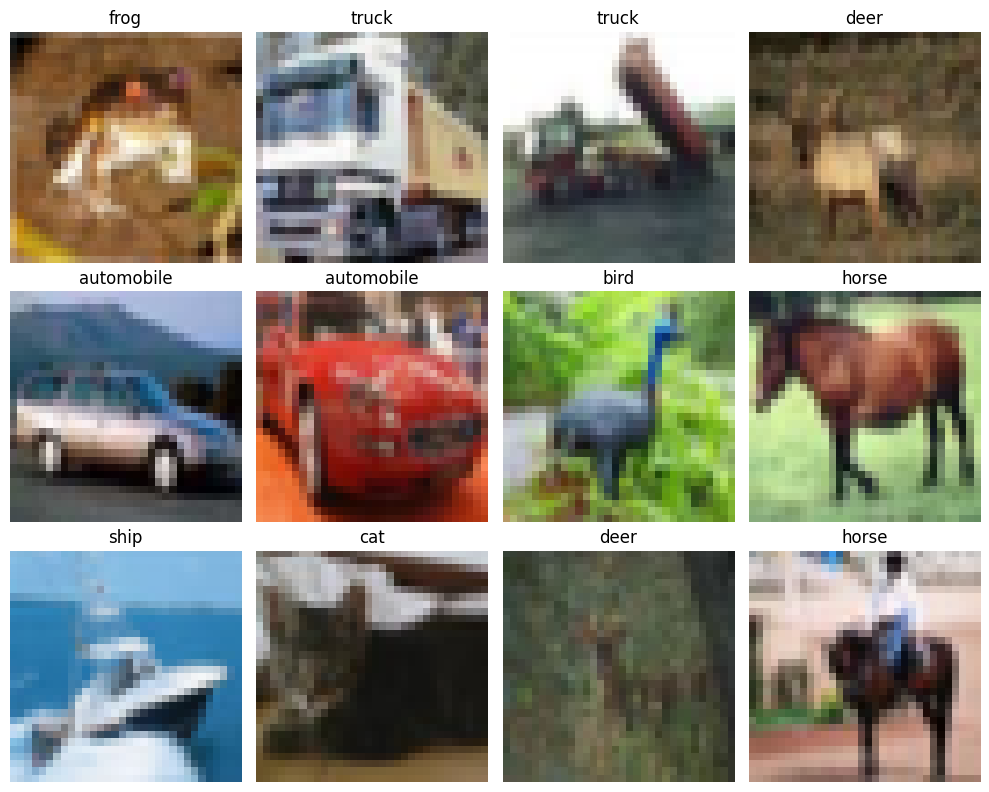

labels
frog          6000
truck         6000
deer          6000
automobile    6000
bird          6000
horse         6000
ship          6000
cat           6000
dog           6000
airplane      6000
Name: count, dtype: int64


In [3]:
print("Training samples:", len(train), "Test samples:", len(test))

#view shape
img, label = train[0]
img_array = np.array(img)
print("Image shape:", img_array.shape)

#pull this info from the class
print(type(img))
print("datatype of each channel:", img_array.dtype) 
print("min of channels:", np.iinfo(img_array.dtype).min) 
print("max of channels:", np.iinfo(img_array.dtype).max)

#show pics
def show_images(dataset, n=12):
    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
    for i, ax in enumerate(axes.flat):
        img, label = dataset[i]

        ax.imshow(img)
        ax.set_title(classes[label])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_images(train, n=12)

#all pics
all_targets = train.targets + test.targets
label_dict = dict(enumerate(classes))
all_targets_df = pd.DataFrame({"targets": all_targets})
all_targets_df["labels"] = all_targets_df["targets"].map(label_dict)
print(all_targets_df["labels"].value_counts())

So we have 50k training images and 10k testing images already broken up for us. These are PIL images These images are 32x32 pixels with 3 channels (RGB), min max of each channel is 255. The data is balanced with 6k pictures for each of the 10 labels.

Lets have a look some images of cats, visually inspecting the images.

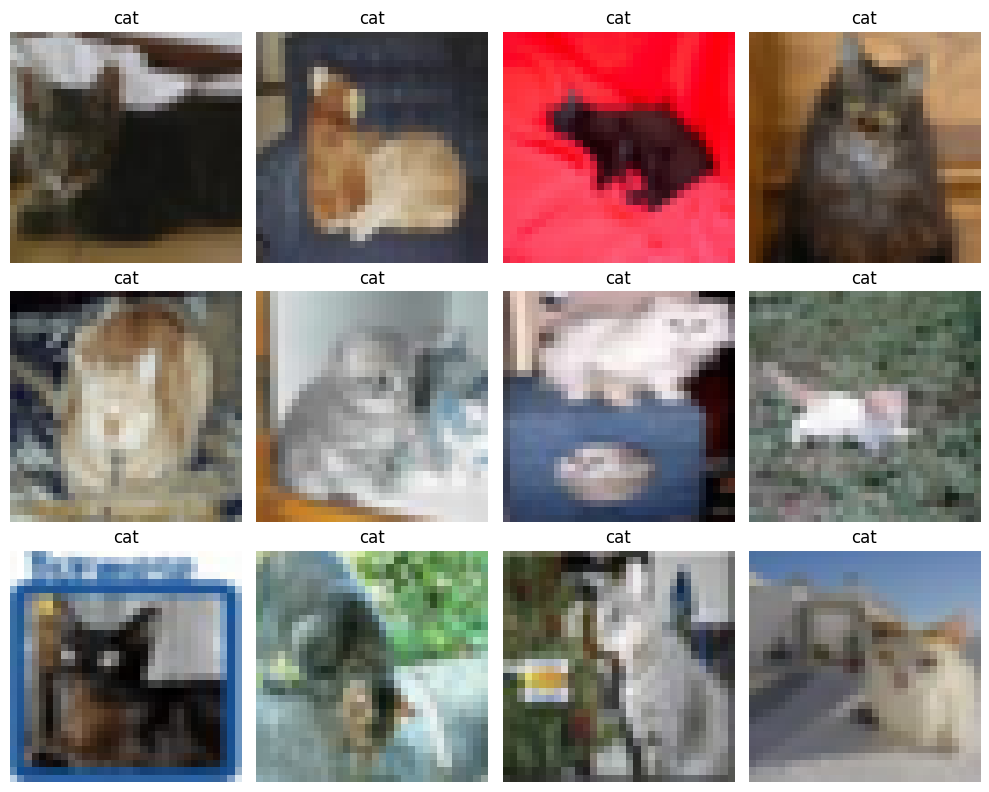

In [7]:
#lets view some cats!
targets = np.array(train.targets)
cat_indices = np.where(targets == 3)[0]
cat_subset = Subset(train, cat_indices)
show_images(cat_subset, n=12)


OK, this is interesting. As a human theres definitely a few here that I would not identify as cats. Additionally, it looks like some of these aren't just photos of cats. For instance the 9th picture appears to have a blue border, and possibly the name of the cat as embedded in the image. With this complication, and the lack of pixel quality, we may not be able to do things like removing the background to help the model.

# Aim

The aim of this work is to investigate various classification techniques, ideally beating the estimated human accuracy of 94% [(Ho-Phuoc, 2019)](https://arxiv.org/abs/1811.07270).

# Traditional techniques
## Clustering
### Dimension reduction

Before we move on to more modern approaches, can we employ clustering methods and assess their effectiveness? These approaches are unlikely to give good results, as they are not optimised for image recognition. As such, I will use a random sampling approach to reduce the time required to complete whilst still giving a good idea of their strengths and weaknesses and allow us to compare them. I am going to use a standard scaler here as I'm expecting to use PCA and some other statistical models which benefit from equlaised variance and comparable features [(GeeksforGeeks, 2020)](https://www.geeksforgeeks.org/machine-learning/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/).

In [2]:
# random balanced sampling
sample_per_class = 1000
X_list, y_list, cifar10_index_list = [], [], []

for cls in range(len(classes)):
    # Filter indices for this class
    cls_indices = np.where(np.array(train.targets) == cls)[0]
    # Random sample from those indices
    chosen = np.random.choice(cls_indices, sample_per_class, replace=False)
    
    # Flatten images and collect
    X_list.append(train.data[chosen].reshape(sample_per_class, -1))
    y_list.append(np.array(train.targets)[chosen])
    cifar10_index_list.append(chosen)  # preserve original CIFAR-10 indices

# Concatenate into final arrays
X = np.vstack(X_list)
y = np.concatenate(y_list)
sample_indices = np.concatenate(cifar10_index_list)  # original CIFAR-10 indices

# RGB is 0-255; scale for PCA, SVM, etc.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

NameError: name 'train' is not defined

We can reduce dimensionality here by employeeing PCA and UMAP (recreating methodology from an NLP method - BERTopic [(Grootendorst, 2024)](https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html)). UMAP is likely better placed to assist in clustering image classification tasks as it preserves local neighbourhoods. 

PCA can be evaluated by using a skree plot against explained variance. UMAP uses a different metric, the one I've chosen here is trustworthiness which "measure how well a data’s structure is preserved after dimensionality reduction" [(Medium.com, 2025)](https://medium.com/data-science/on-the-validating-umap-embeddings-2c8907588175).

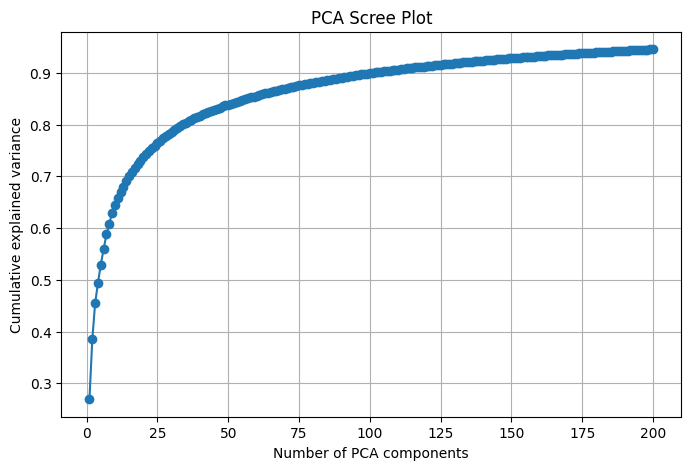

c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\nexus\Documents\rew\masters\mla

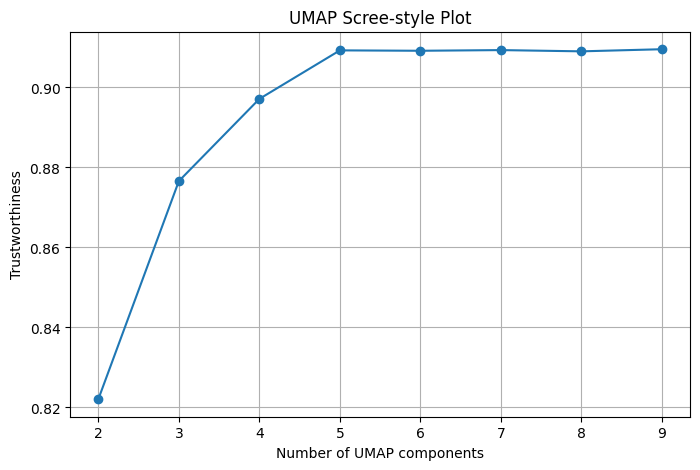

In [ ]:
#WARNING this chunk takes a long time to finish
#pca scree plot
pca = PCA(n_components=200, random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative)+1), cumulative, marker="o")
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

#umap trustworthiness
dims = range(2,10)
trust_scores = []

#i've chosen 15 neighbors here as a performance trade off. likely larger values here might increase performance
for d in dims:
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=d, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)
    score = trustworthiness(X_scaled, X_umap, n_neighbors=10)
    trust_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(dims, trust_scores, marker="o")
plt.xlabel("Number of UMAP components")
plt.ylabel("Trustworthiness")
plt.title("UMAP Scree-style Plot")
plt.grid(True)
plt.show()


The PCA skree shows that, after an inital sharp increase in explained variance (around 25 components), the relationship with explained variance become mostly linear, with more components explaining slightly more variance. Rather than looking for the usual elbow, I will use a number of components that explains ~80% of the variance. For this case I will use 30 components.

UMAPs trustworthiness skree plot suggests using 5 components, maximising trustworthiness as >0.9.

In [ ]:
#components chosen
pca_components = PCA(n_components=25, random_state=42)
X_pca_components = pca_components.fit_transform(X_scaled)

umap_components = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=5, random_state=42)
X_umap_components = umap_components.fit_transform(X_scaled)

c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Now that we have reduced the dimesionality, we can fit and assess our results. As I know how many classes there are we can use that to inform KMeans. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) and HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) will "discover" the number of clusters on their own. These metrics do not measure "accuracy" as clustering does not identify what a cluster is (dog, cat bird).

Here I am using three metrics to assess the results
* Silhouette
    * "The Silhouette Score measures how similar a data point is to its own cluster compared to other cluster" [(Medium.com, 2024)](https://farshadabdulazeez.medium.com/understanding-silhouette-score-in-clustering-8aedc06ce9c4). This is comparing how distinct the clusters are. 1 means perfect clustering, -1 means poor clustering.
* ARI
    * Adjusted Rand Index "computes the similarity between discovered communities and ground-truth communities, and is defined such that its expected value is zero when clusters are selected by chance and one when a perfect match is achieved" [(www.sciencedirect.com, n.d.)](https://www.sciencedirect.com/topics/computer-science/adjusted-rand-index). It's a pairwise metric that compares their ground truths (would they be together?) against a random designation. Therefore, if the points are classified in a fashion thats worse than random, ARI can be -1. If they are perfectly classified ARI will be 1.
* NMI
    * Normalised Multial Info is a correlation metric between the cluster and the ground truth [(Mathworks.com, 2025)](https://www.mathworks.com/matlabcentral/fileexchange/130784-normalized-mutual-information-nmi-for-cluster-analysis). 1 means perfect clustering, 0 means no mutual information/no correltation to ground truth (totally random cluster).

Importantly, none of these metrics directly compare ground truth, like traditional metrics such as accuracy does, as a clustering algorithm has no way to know what its output actually is (is cluster 1 a cat or a dog?).

In [ ]:
results = {}
results["PCA_KMeans"] = KMeans(n_clusters=10, n_init=10, random_state=42).fit_predict(X_pca_components)
results["PCA_DBSCAN"] = DBSCAN(eps=1.5, min_samples=20).fit_predict(X_pca_components)
results["PCA_HDBSCAN"] = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=20).fit_predict(X_pca_components)
results["UMAP_KMeans"] = KMeans(n_clusters=10, n_init=10, random_state=42).fit_predict(X_umap_components)
results["UMAP_DBSCAN"] = DBSCAN(eps=0.5, min_samples=10).fit_predict(X_umap_components)
results["UMAP_HDBSCAN"] = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=20).fit_predict(X_umap_components)
results["RAW_KMeans"] = KMeans(n_clusters=10, n_init=10, random_state=42).fit_predict(X_scaled)
results["RAW_DBSCAN"] = DBSCAN(eps=3.0, min_samples=20).fit_predict(X_scaled)
results["RAW_HDBSCAN"] = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=20).fit_predict(X_scaled)

def eval_clustering(labels, X_embed, name):
    #ARI/NMI need true labels aligned with the same number of samples
    ari = adjusted_rand_score(y, labels)
    nmi = normalized_mutual_info_score(y, labels, average_method="arithmetic")
    #silhouette needs at least 2 clusters (and not all -1 noise)
    sil = silhouette_score(X_embed, labels) if len(np.unique(labels)) > 1 else np.nan
    print(f"{name:12s} | ARI={ari:.4f}, NMI={nmi:.4f}, Silhouette={sil:.4f}")
    return {"ARI": ari, "NMI": nmi, "Silhouette": sil}

scores = {}
for key, labels in results.items():
    if key.startswith("PCA_"):
        scores[key] = eval_clustering(labels, X_pca_components, key)
    else:
        if X_umap_components is not None:
            scores[key] = eval_clustering(labels, X_umap_components, key)


c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: '

PCA_KMeans   | ARI=0.0409, NMI=0.0787, Silhouette=0.0767
PCA_DBSCAN   | ARI=0.0000, NMI=0.0000, Silhouette=nan
PCA_HDBSCAN  | ARI=0.0000, NMI=0.0000, Silhouette=nan
UMAP_KMeans  | ARI=0.0437, NMI=0.0791, Silhouette=0.2962
UMAP_DBSCAN  | ARI=-0.0000, NMI=0.0003, Silhouette=-0.1959
UMAP_HDBSCAN | ARI=0.0085, NMI=0.0645, Silhouette=-0.1035
RAW_KMeans   | ARI=0.0415, NMI=0.0798, Silhouette=0.2084
RAW_DBSCAN   | ARI=0.0000, NMI=0.0000, Silhouette=nan
RAW_HDBSCAN  | ARI=0.0000, NMI=0.0000, Silhouette=nan


These results are to be expected as clustering images such as this is unlikely to give effective results. As DBSCAN and HDBSCAN don't know the number of classes that they need, in most cases, they have failed, creating one giant cluster (see below visuals). KMeans has done by far the best of the three algorithms, but it has the advantage of at least knowing that there are 10 classes to shoot for.

UMAP KMeans has outperformed PCA and raw, with a silhouette of 0.29 (there is some distinction between the clusters, they don't all totally overlap) and very slightly positive ARI and NMI (the cluster is not totally random and there is some actual correlation back to the ground truth). However, this result is very minor.

Lets view the results in 2d space. The below is the PCA space with the true/ground truth labels.

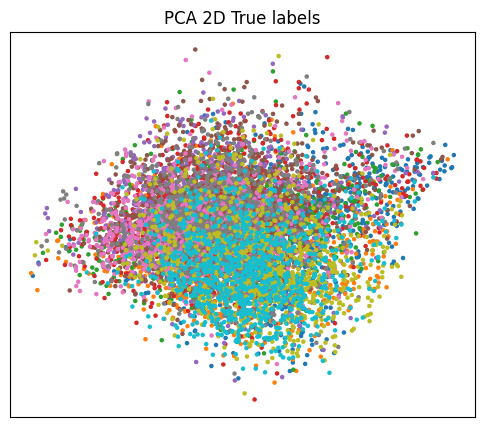

In [ ]:
def plot_embedding(emb, labels, title):
    plt.figure(figsize=(6,5))
    plt.scatter(emb[:,0], emb[:,1], c=labels, s=5, cmap="tab10")
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.show()

# True labels vs clusters
plot_embedding(X_pca_components, y, "PCA 2D True labels")


The PCA space does seem to show some clustering, with the teal points showing some tendency towards the bottom of the PCA space. Only KMeans showed any usefulness in the metrics. Lets look at that vs one of the other methods.

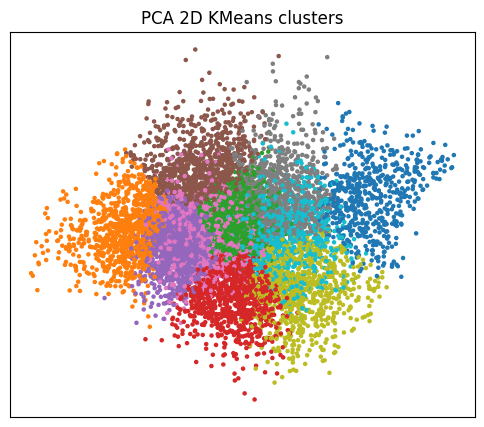

In [ ]:
plot_embedding(X_pca_components, results["PCA_KMeans"], "PCA 2D KMeans clusters")

PCA Kmeans does look to be reflecting the shapes observed in the true labels a bit, but only very slightly. How did the other clustering algorithms do.

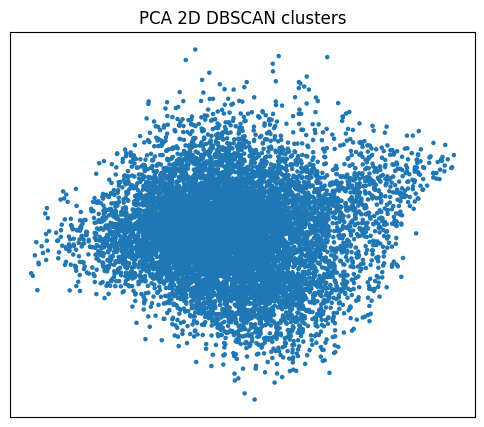

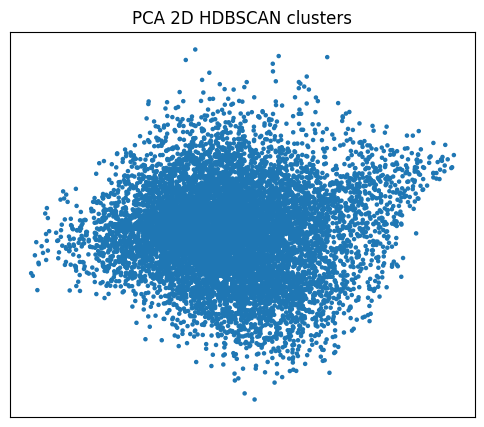

In [ ]:
plot_embedding(X_pca_components, results["PCA_DBSCAN"], "PCA 2D DBSCAN clusters")
plot_embedding(X_pca_components, results["PCA_HDBSCAN"], "PCA 2D HDBSCAN clusters")

OK, now we can see why the metrics were so poor. Neither algorithm has identified any clustering at all. To be fair, the space does not suggest any distinct clusters, so I can see why they would return this results.

How does the UMAP space look?

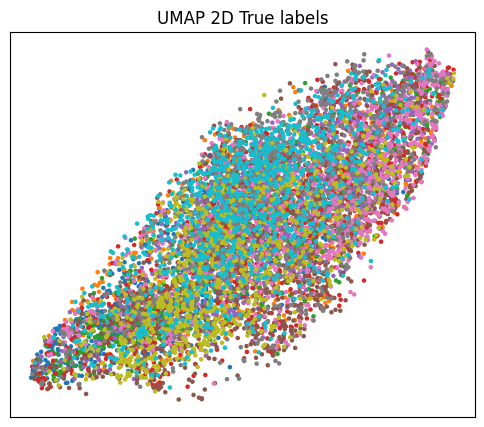

In [ ]:
plot_embedding(X_umap_components, y, "UMAP 2D True labels")

Again I can see some pattern, but no obviously distinct clusters.

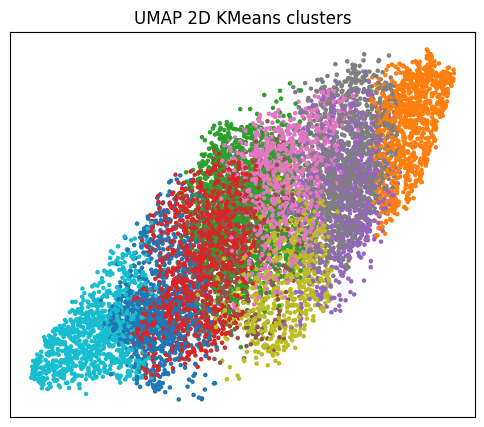

In [ ]:
plot_embedding(X_umap_components, results["UMAP_KMeans"], "UMAP 2D KMeans clusters")

Visually, this does look more similar to the true labels.

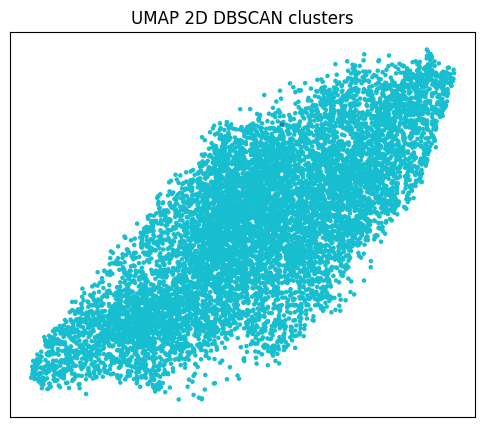

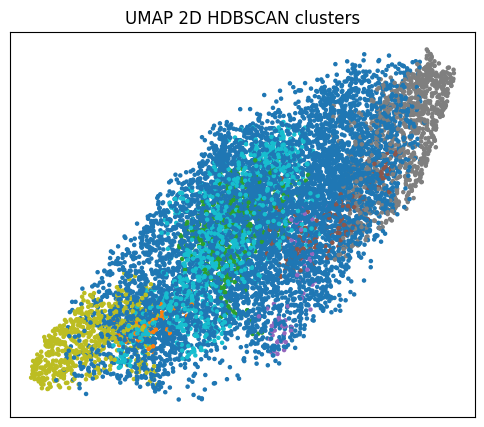

In [ ]:
plot_embedding(X_umap_components, results["UMAP_DBSCAN"], "UMAP 2D DBSCAN clusters")
plot_embedding(X_umap_components, results["UMAP_HDBSCAN"], "UMAP 2D HDBSCAN clusters")

Interesting that HDBSCAN has managed such a better job using the UMAP space against the PCA space. I'm interested to have a quick look at a few of the UMAP KMeans clusters and see if I can visually understand why they've been clustered together. The below is some images from cluster 4 and their actual class.

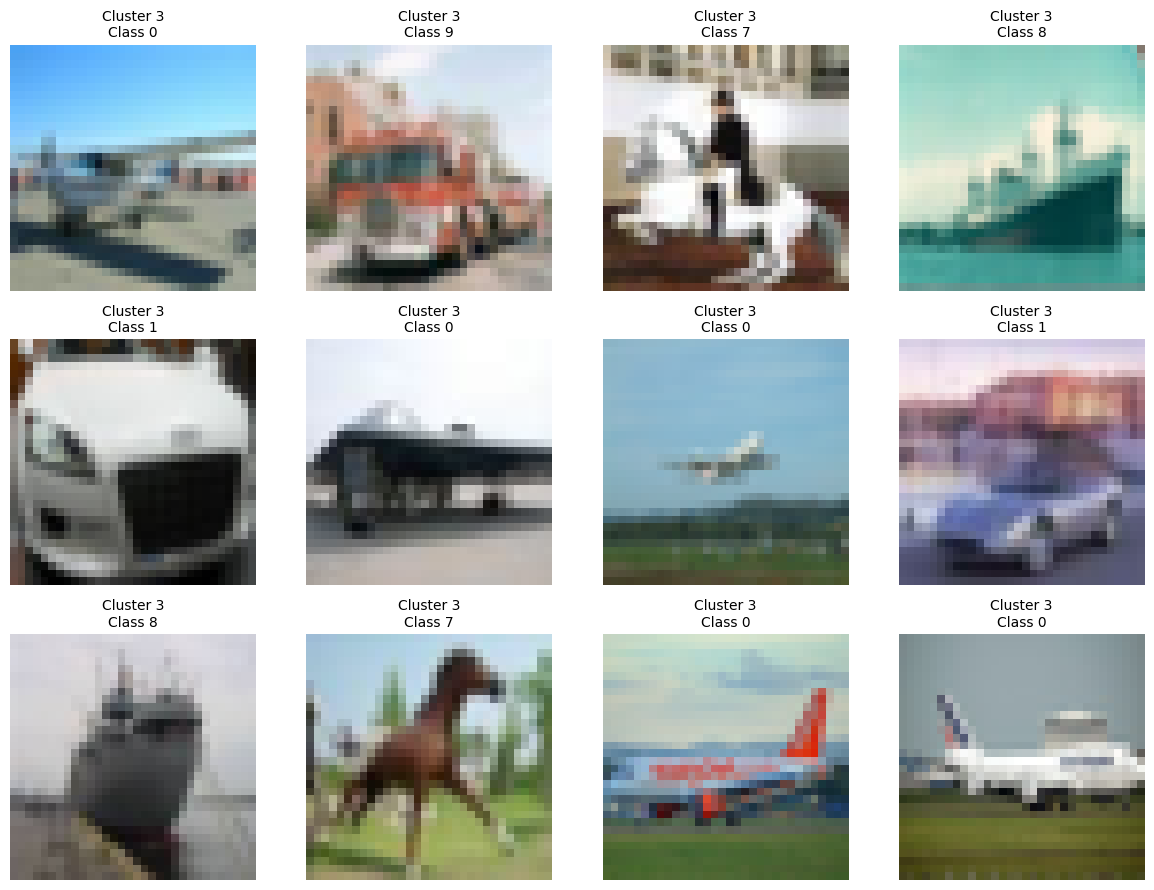

In [ ]:
df = pd.DataFrame({
    "res_ind": results["UMAP_KMeans"],
    "cifar10_ind": sample_indices
})

cluster_indices = df.loc[df["res_ind"] == 3, "cifar10_ind"].values
chosen = np.random.choice(cluster_indices, 12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for ax, idx in zip(axes, chosen):
    img, label = train[idx]  
    ax.imshow(img)
    ax.set_title(f"Cluster 3\nClass {label}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

Blues and whites?

What about a PCA equivalent?

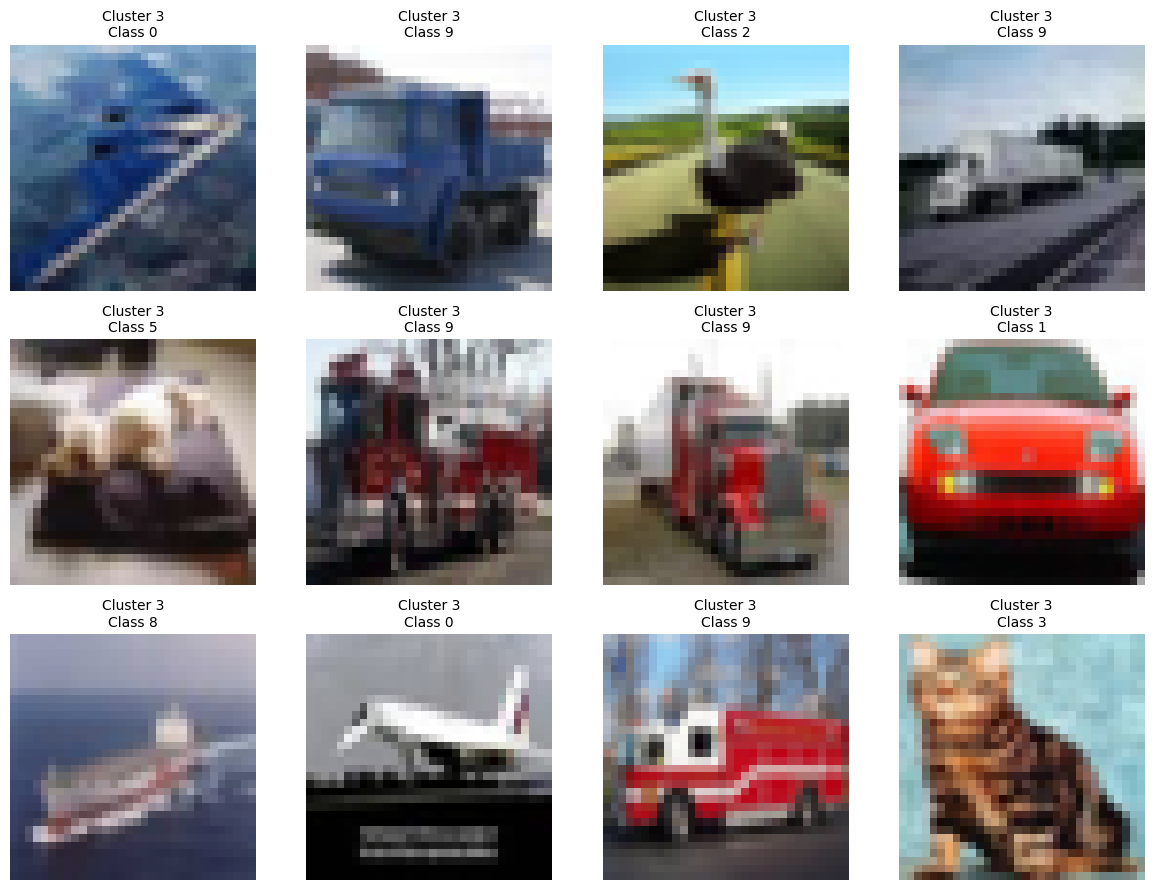

In [ ]:
df = pd.DataFrame({
    "res_ind": results["PCA_KMeans"],
    "cifar10_ind": sample_indices
})

cluster_indices = df.loc[df["res_ind"] == 3, "cifar10_ind"].values
chosen = np.random.choice(cluster_indices, 12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for ax, idx in zip(axes, chosen):
    img, label = train[idx]  
    ax.imshow(img)
    ax.set_title(f"Cluster 3\nClass {label}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

Blues and reds? I can't see much of a pattern.

# Machine Learning

Clustering has performed as expected. If we move on to Machine learning can we improve the results? These models can take a long time, so I will randomly sampling 2000 out of the 10000 (balancing for the classes, so each test/training has the same number of images per class).

I am testing 5 classification models here
* Decision tree
* Random Forest
* Support Vertor Machine (SVM) with Radial Basis Funciton Kernel (RBF)
    * RBF can handle nonlinear decision boundaries so is a better fit for image classification over polynomial and linear kernels [(Al-Mejibli et al., 2018)](https://www.researchgate.net/profile/Jwan-Alwan/publication/331108441_Performance_Evaluation_of_Kernels_in_Support_Vector_Machine/links/6130ed9ec69a4e487975d000/Performance-Evaluation-of-Kernels-in-Support-Vector-Machine.pdf)
* K Nearest Neighbors
* XGBoost

scaling the data and applying 3 data transformations (scaled user standard scaler, mean of 0 sd of 1. SVM and KNN require scaling. Tree models are agnostic so has no effect).
* Raw (no transformation)
* PCA
* UMAP

resulting in training and testing 15 models.

As the models have the truth when testing, we can use accuracy and f1 score to evaluate them. Accuracy tells us how well they've performed over all classes, but can hide detail if a model has some classes that it performs better at than others. F1 attempts to balance precision and recall, concentrating on false positives and negatives. These two metrics tell us two sides of the same coin, accuracy tells us how often the models are right, F1 is looking at how well the models classify with a more balanced view across classes [(Kundu, 2022)](https://www.v7labs.com/blog/f1-score-guide).

In [3]:
#warning takes approx 2 mins
SAMPLE_SIZE = 2000

# data prep
X_train = train.data.reshape(len(train.data), -1)
y_train = np.array(train.targets)

X_test  = test.data.reshape(len(test.data), -1)
y_test  = np.array(test.targets)

# Sample subset
frac = SAMPLE_SIZE / len(X_train)
sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=42)
sample_idx, _ = next(sss.split(X_train, y_train))
X_train = X_train[sample_idx]
y_train = y_train[sample_idx]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Transformations
pca_ml = PCA(n_components=20, random_state=42).fit(X_train_scaled)
umap_ml = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=5, random_state=42)

transformations = {
    "Raw": (X_train_scaled, X_test_scaled),
    "PCA": (pca_ml.transform(X_train_scaled), pca_ml.transform(X_test_scaled)),
    "UMAP": (umap_ml.fit_transform(X_train_scaled), umap_ml.transform(X_test_scaled))
}

c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


I now have my data prep done (scaling and different approaches to dimension reduction).

In [7]:
#training takes approx 7 mins
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
LOAD_MODELS_ONLY = False # if true skip training saves about 5-6mins

models = {
    "DecisionTree": DecisionTreeClassifier(max_depth=30, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    "SVM_RBF": SVC(kernel="rbf", C=5.0, gamma="scale"),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights="distance"),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="mlogloss"
    )
}

os.makedirs("confusion_matrices", exist_ok=True)

results = []

for tname, (Xtr, Xte) in tqdm(transformations.items(), desc="Transformations", position=0):
    for mname, model in tqdm(models.items(), desc=f"Models ({tname})", leave=False, position=1):

        model_path = f"saved_models/{mname}_{tname}.pkl"
        cm_path    = f"confusion_matrices/{mname}_{tname}.png"

        #train
        if not LOAD_MODELS_ONLY:
            mdl = model.fit(Xtr, y_train)
            with open(model_path, "wb") as f:
                pickle.dump(mdl, f)
        else:
            if os.path.exists(model_path):
                with open(model_path, "rb") as f:
                    mdl = pickle.load(f)
            else:
                continue  # skip if model doesn't exist

        preds = mdl.predict(Xte)

        #metrics
        acc  = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds, average="macro", zero_division=0)
        rec  = recall_score(y_test, preds, average="macro", zero_division=0)
        f1   = f1_score(y_test, preds, average="macro", zero_division=0)

        per_class_acc = {}
        for i, cls in enumerate(classes):
            mask = (y_test == i)
            per_class_acc[cls] = accuracy_score(y_test[mask], preds[mask]) if mask.any() else np.nan

        #vis
        cm = confusion_matrix(y_test, preds, labels=range(len(classes)))

        plt.figure(figsize=(7,6))
        sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                    xticklabels=classes, yticklabels=classes)
        plt.title(f"Confusion Matrix {mname} ({tname})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.savefig(cm_path)
        plt.close()

        results.append({
            "Transformation": tname,
            "Model": mname,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "PerClassAccuracy": per_class_acc,
            "ModelFile": model_path,
            "ConfusionMatrixFile": cm_path
        })

results_df = pd.DataFrame(results)
print(results_df[["Transformation", "Model", "Accuracy", "F1"]])

Transformations: 100%|██████████| 3/3 [05:50<00:00, 116.96s/it]

   Transformation         Model  Accuracy        F1
0             Raw  DecisionTree    0.2054  0.204168
1             Raw  RandomForest    0.3704  0.364235
2             Raw       SVM_RBF    0.4104  0.410027
3             Raw           KNN    0.2728  0.250524
4             Raw       XGBoost    0.4013  0.398018
5             PCA  DecisionTree    0.2199  0.218844
6             PCA  RandomForest    0.3724  0.368150
7             PCA       SVM_RBF    0.3830  0.381453
8             PCA           KNN    0.3135  0.308219
9             PCA       XGBoost    0.3782  0.376156
10           UMAP  DecisionTree    0.1815  0.179785
11           UMAP  RandomForest    0.2381  0.235891
12           UMAP       SVM_RBF    0.2652  0.232004
13           UMAP           KNN    0.2443  0.240935
14           UMAP       XGBoost    0.2450  0.239863


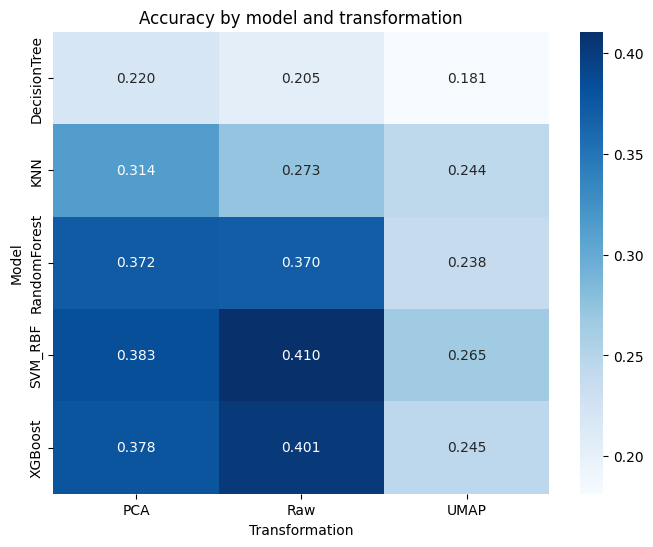

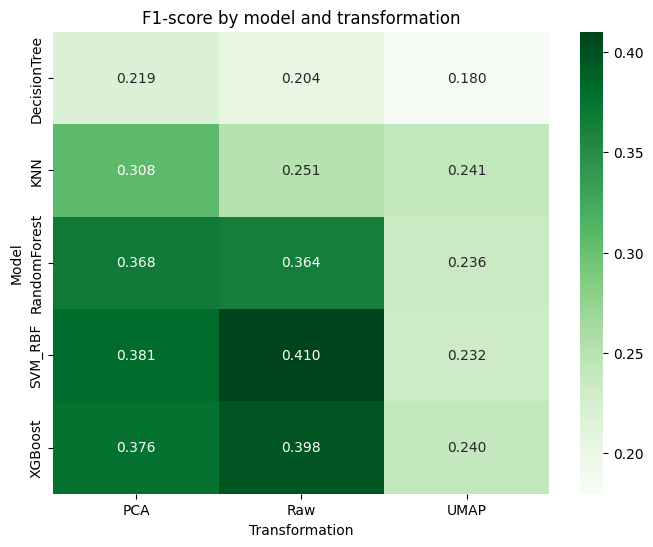

In [8]:
pivot_acc = results_df.pivot(index="Model", columns="Transformation", values="Accuracy")
plt.figure(figsize=(8,6))
sns.heatmap(pivot_acc, annot=True, fmt=".3f", cmap="Blues")
plt.title("Accuracy by model and transformation")
plt.show()

pivot_f1 = results_df.pivot(index="Model", columns="Transformation", values="F1")
plt.figure(figsize=(8,6))
sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="Greens")
plt.title("F1-score by model and transformation")
plt.show()

Using this sample we can see that PCA helps KNN and RF but no other models. UMAP models have performed far worse, with the raw models (scaing only) out performing the pre-processed models pretty much universally. SVM has done a suprisingly good job here with a comparable accuracy score to the next best model, xgboost. However, it appears that xgboost has a lower F1 score so probably has a particularly well performing class which is bringing its accuracy up.

Lets compare these models directly on each class's performance. This will allow us to see the strengths and weaknesses of the models.

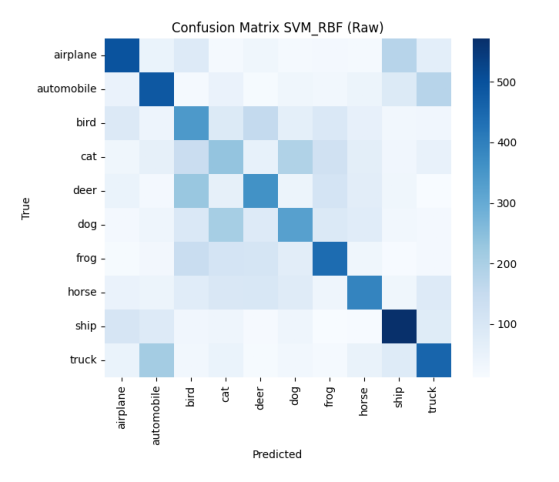

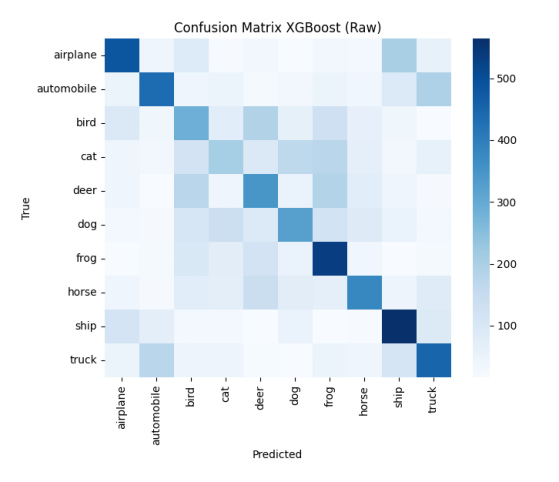

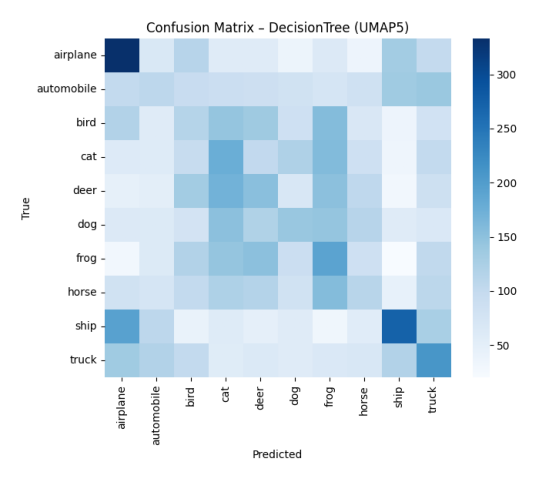

In [9]:
img = mpimg.imread(os.path.join("confusion_matrices", "SVM_RBF_Raw.png"))
plt.figure(figsize=(7,6))
plt.imshow(img)
plt.axis("off")
plt.show()

img = mpimg.imread(os.path.join("confusion_matrices", "XGBoost_Raw.png"))
plt.figure(figsize=(7,6))
plt.imshow(img)
plt.axis("off")
plt.show()

img = mpimg.imread(os.path.join("confusion_matrices", "DecisionTree_UMAP5.png"))
plt.figure(figsize=(7,6))
plt.imshow(img)
plt.axis("off")
plt.show()

We can see that xgboost and svm do quite well, with ships and airplanes being well classified. Xgboost also does well with frogs, but quite poorly with cats, thinking that they are dogs or cats. This is probably what has caused the dip in the F1 score.

## Hyperparameter tuning

Above I attempted to train XGBoost, and it did quite well, especially considering that I have randomly chosen its parameters. How about if I use some hyperparameter tuning techniques such as grid search. I've chosen XGBoost and PCA as they did the best of the "tuneable" models above. I could tune RAW but this would take a huge amount of time due to the high dimensionality of the data and the nature of gridsearch (training many models).

I have provided a "grid" of standard values to try and the model trains on all permutations of these values and we will train using 2/3s of the training data (training twice) with the last 1/3 used to validate. Once we have the best performing model against the validation set, giving us our final hyperparameters. This model is then trained against all the training data. We finally test it against the test set.

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Saved tuned model to: saved_models/XGBoost_Raw_Tuned.pkl
      Metric     Value
0   Accuracy  0.379300
1  Precision  0.378499
2     Recall  0.379300
3   F1 Score  0.377724


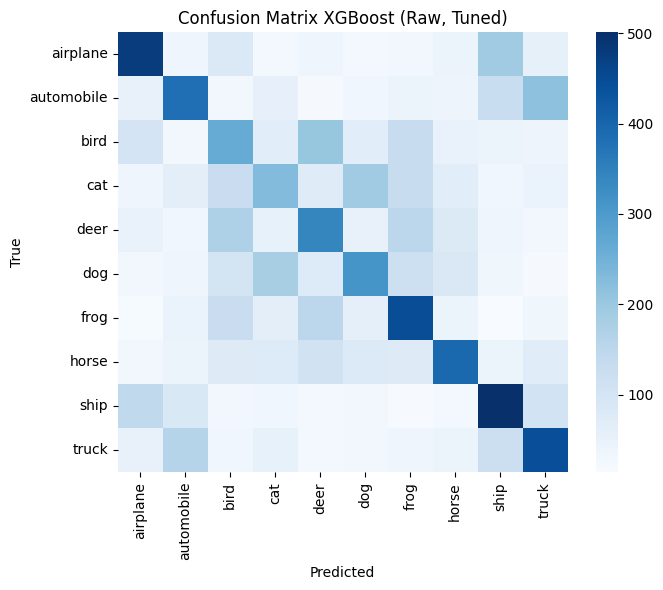

In [6]:
Xtr = transformations["PCA"][0]
Xte = transformations["PCA"][1]

xgb_base = XGBClassifier( eval_metric="mlogloss", random_state=42, n_jobs=1 )
param_grid = {
    "n_estimators": [100, 200], 
    "max_depth": [4, 6, 8], 
    "learning_rate": [0.05, 0.1, 0.2], 
    "subsample": [0.8, 1.0], 
    "colsample_bytree": [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=xgb_base, 
    param_grid=param_grid, 
    scoring="accuracy", 
    cv=5, 
    verbose=2, 
    n_jobs=5
)

grid.fit(transformations["PCA"][0], y_train)

best_model = grid.best_estimator_

os.makedirs("saved_models", exist_ok=True)
model_path = "saved_models/XGBoost_Raw_Tuned.pkl"

with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"Saved tuned model to: {model_path}")

preds = best_model.predict(Xte)

acc = accuracy_score(y_test, preds) 
prec = precision_score(
    y_test, 
    preds, 
    average="macro", 
    zero_division=0
) 
rec = recall_score(
    y_test, 
    preds, 
    average="macro", 
    zero_division=0
) 
f1 = f1_score(
    y_test, 
    preds, 
    average="macro", 
    zero_division=0
)

metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"], 
    "Value": [acc, prec, rec, f1]
}) 
print(metrics_table)

cm = confusion_matrix(y_test, preds, labels=range(len(classes)))

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix XGBoost (Raw, Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Tuning the hyper parameters has increased our accuracy slightly, from 37.8% to 37.9%.

# Neural Networks
## Shallow net

Here I shall explore a shallow neural network using Multi-Layer Perceptron (MLP) architecture [(GeeksforGeeks, 2021)](https://www.geeksforgeeks.org/deep-learning/multi-layer-perceptron-learning-in-tensorflow/) using pytorch [(Tam, 2023)](https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/). 

The workflow here is to split the data into 3
* Train data. Used to train the model only.
* Validation data. Used to assess the model duing training only.
* Test data. Totally unseen by the model during training and used against the final model once only.

This workflow seeks to limit data leakage [(Wikipedia Contributors, 2024)](https://en.wikipedia.org/wiki/Leakage_(machine_learning)) during training.

Each photo is flattened into a 3072 pixel values mapped to 3072 weights outputting 512 neurons as a hidden layer, each neuron has access to the 3072 weights. These intial weights are randomised. There is a RELU activation layer making neurons tha return a negative value return 0, leaving positive values untouched. This makes it easier for the next layer to learn. Because we are using a RELU layer we are normalizing the pixel range from 0->1 (default for tensors) to -1->1 [(He et al., 2015)](https://arxiv.org/abs/1502.01852). This output is then passed to 10 neurons finally returning 10 logits. The index of the largest logit determines its class. We use a loss function to understand how accurate the model thought it was going to be against what it actually predicted. Crossentropy loss compares these raw logits against the hard target (class label). There are other loss functions we could employ but crossentropy is designed for multiclass single label scenarios like this [(Brownlee, 2019)](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/). The gradients of the neurons are then updated using backpropogation, attempting to "nudge" them towards becoming more accurate. These nudgese are controlled by the optimiser, here I've used Adam [(Kingma and Ba, 2014)](https://arxiv.org/abs/1412.6980). I've chosen Adam here as it's considered the fastest and most performant modern optimiser using crossentropy loss as its measure of success.
However, I do expect this method not to perform particularly well as it has no way to understand the underlying structures of an image [(Schaijk, n.d.)](https://www.peculiar-coding-endeavours.com/2019/mlp_vs_cnn/). The best model is chosen for the best accuracy against the validation data, I've chosen accuracy here because I am using hard targets (the class not the probability of the class) and a fixed number of epochs.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5),
                                     (0.5, 0.5, 0.5))
])

# load full training set
trainset_full = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# split into train + validation 
train_size = int(0.9 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, valset = random_split(trainset_full, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=128)

# final test set
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=128)

classes = trainset_full.classes

def train_eval(model, trainloader, valloader, epochs=20, lr=0.001, device=None):
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    best_val_acc = 0
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct_train += (pred == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct_train / total_train
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        #validation
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logits = model(inputs)

                loss = criterion(logits, labels)
                val_running_loss += loss.item()

                _, pred = torch.max(logits, 1)
                correct_val += (pred == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct_val / total_val
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch:03d}/{epochs} | "
              f"TrainLoss {train_loss:.3f} | ValLoss {val_loss:.3f} | "
              f"TrainAcc {train_acc:.2f}% | ValAcc {val_acc:.2f}%")

        # save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    model.load_state_dict(best_state)

    return {
        "train_loss": train_loss_list,
        "val_loss": val_loss_list,
        "train_acc": train_acc_list,
        "val_acc": val_acc_list,
        "best_val_acc": best_val_acc,
        "best_model": model
    }

#final test
def final_test(model, testloader, device=None):
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)

            _, pred = torch.max(logits, 1)

            all_preds.append(pred.cpu())
            all_labels.append(labels.cpu())
            all_logits.append(logits.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_logits = torch.cat(all_logits)

    # Metrics
    acc = (all_preds == all_labels).float().mean().item()
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    # Reliability curve
    probs = torch.softmax(all_logits, dim=1)
    conf, pred_class = probs.max(dim=1)
    conf = conf.numpy()
    correct_mask = (pred_class.numpy() == all_labels.numpy())

    bins = 10
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_conf, bin_acc = [], []

    for i in range(bins):
        mask = (conf >= bin_edges[i]) & (conf < bin_edges[i + 1])
        if mask.sum() > 0:
            bin_conf.append(conf[mask].mean())
            bin_acc.append(correct_mask[mask].mean())
        else:
            bin_conf.append((bin_edges[i] + bin_edges[i + 1]) / 2)
            bin_acc.append(np.nan)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "reliability_conf": bin_conf,
        "reliability_acc": bin_acc
    }


In [23]:
#warning 7 mins
#define model
#init weights are random by default
class ShallowNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
        
net = ShallowNet() 
metrics = train_eval(net, trainloader, valloader, epochs=20) 
best_model = metrics["best_model"] 
test_metrics = final_test(best_model, testloader) 

Epoch 001/20 | TrainLoss 1.669 | ValLoss 1.602 | TrainAcc 41.66% | ValAcc 44.62%
Epoch 002/20 | TrainLoss 1.483 | ValLoss 1.518 | TrainAcc 48.28% | ValAcc 46.34%
Epoch 003/20 | TrainLoss 1.390 | ValLoss 1.495 | TrainAcc 52.00% | ValAcc 47.94%
Epoch 004/20 | TrainLoss 1.325 | ValLoss 1.540 | TrainAcc 54.38% | ValAcc 47.86%
Epoch 005/20 | TrainLoss 1.256 | ValLoss 1.497 | TrainAcc 57.08% | ValAcc 50.78%
Epoch 006/20 | TrainLoss 1.201 | ValLoss 1.548 | TrainAcc 59.03% | ValAcc 49.34%
Epoch 007/20 | TrainLoss 1.145 | ValLoss 1.520 | TrainAcc 60.83% | ValAcc 51.18%
Epoch 008/20 | TrainLoss 1.086 | ValLoss 1.597 | TrainAcc 63.12% | ValAcc 51.04%
Epoch 009/20 | TrainLoss 1.032 | ValLoss 1.564 | TrainAcc 64.82% | ValAcc 51.94%
Epoch 010/20 | TrainLoss 0.986 | ValLoss 1.613 | TrainAcc 66.84% | ValAcc 51.58%
Epoch 011/20 | TrainLoss 0.937 | ValLoss 1.670 | TrainAcc 68.20% | ValAcc 51.88%
Epoch 012/20 | TrainLoss 0.900 | ValLoss 1.671 | TrainAcc 69.91% | ValAcc 51.34%
Epoch 013/20 | TrainLoss 0.8

In [24]:
print(
    f"accuracy: {test_metrics['accuracy']}\n"
    f"precision: {test_metrics['precision']}\n"
    f"recall: {test_metrics['recall']}\n"
    f"f1: {test_metrics['f1']}"
)

accuracy: 0.5097000002861023
precision: 0.5141995073726221
recall: 0.5096999999999999
f1: 0.5075360002067771


Using the best model versus the test data, the actual accuracy drops to 50.9 vs 52 using the validation data. This is because the test data is totally unseen, reducing any risk of data leakage. During training, we see a steady increase in accuracy until around epoch 13 and then model gets no better. This can be visualised.

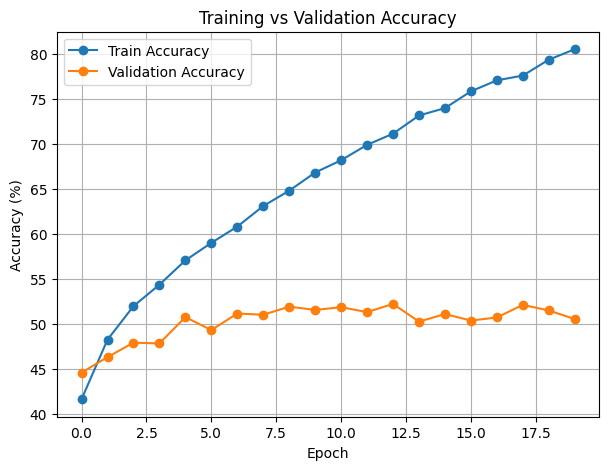

In [25]:
plt.figure(figsize=(7,5))
plt.plot(metrics["train_acc"], label="Train Accuracy", marker='o')
plt.plot(metrics["val_acc"], label="Validation Accuracy", marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()


This plot is showing some classic signs of overfitting. After epoch 13 there is no improvement in the validation accuracy, but the model appears to be getting more accurate when considering only the train data. This is caused as the model is getting better at categorising the training data (as it has seen it multiple times) but is not generalising any better for data it hasn't seen before.

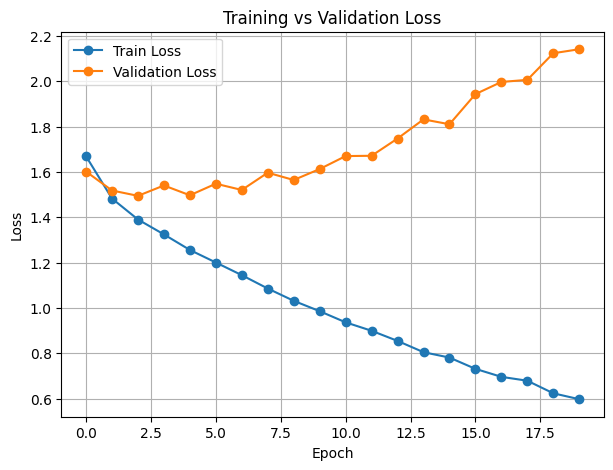

In [29]:
plt.figure(figsize=(7,5))
plt.plot(metrics["train_loss"], label="Train Loss", marker='o')
plt.plot(metrics["val_loss"], label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


The loss chart shows that model is becoming more confident against training data, but the error is getting worse against the validation data. The loss against the validation layer is best at epoch 4 and and then increases steadily.

We can look at some metrics from the last epoch (not our best model).

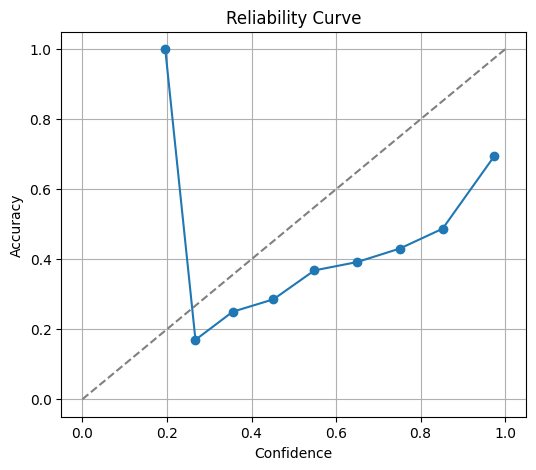

In [28]:
plt.figure(figsize=(6,5))
plt.plot(test_metrics["reliability_conf"], test_metrics["reliability_acc"], marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("Reliability Curve")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


This confidence curve of the best model is showing signs of overfit too i.e. the model is significantly overconfident in its results. As an example when the model thinks it is nearly certain (near 100% confidence) its accuracy is about 70%. There is a particularly odd point at confidence 0.2 where the accuracy is 100%. Likely this is caused by a singular point that was accurate.

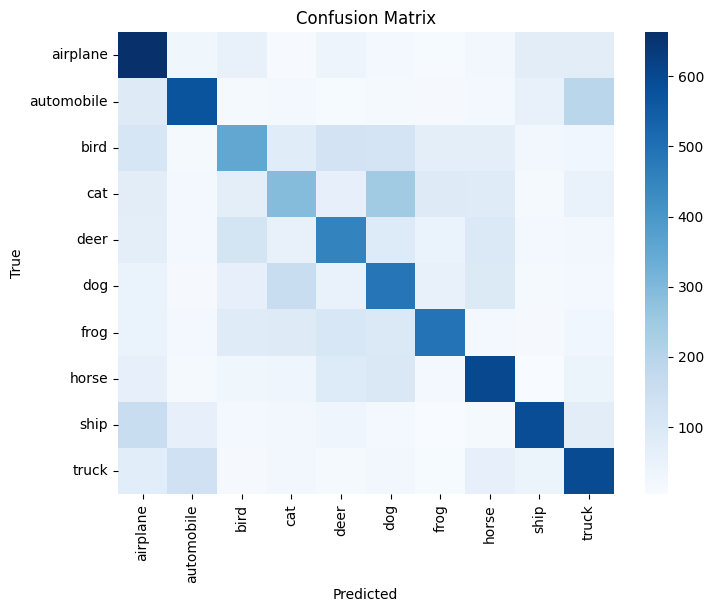

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap(test_metrics["confusion_matrix"],
            annot=False,
            cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


We can see that this model is getting better, but is struggling particularly with cats, deers and dogs, often confusing dogs and cats.

In quick conclusion, this model is outperforming the previous model which was ~40% accurate and this model is ~50% accurate. It is showing signs of over fit and this is likely near the limit of this approach. We could look to improve it by adding additional layers and try different normalisation techniques.

## CNN

A Convolutional Neural Network applies the above techniques (neural network form the MLP) but applies the concept of convolution. This applies learnable filters/kernels that slide over the image, transforming the underlying data [(O’Shea and Nash, 2015)](https://arxiv.org/abs/1511.08458). Each filter/kernel helps the model identify edges, textures, features, as the model becomes more complex.

The below model is designed to run quickly [(GeeksforGeeks, 2024)](https://www.geeksforgeeks.org/deep-learning/building-a-convolutional-neural-network-using-pytorch/). The first layer is a convolution which takes an image of 3 dimensions (RGB), uses a 3x3 pixel kernel and produces 32 output maps. These maps are pooled taking the max activation of a 2x2 filter (halving the size whilst keepinb the most important features) for the 3x3 filter/kernel changing our 32x32 grid into 16x16 [(GeeksforGeeks, 2019)](https://www.geeksforgeeks.org/deep-learning/cnn-introduction-to-pooling-layer/). This is then passed through a ReLU layer to the second convolution layer. This takes the 32 feature maps output by conv1 and the pool layer, applying another 3x3 filter/kernel and outputing 64 maps. These maps are passed to the two neuron layers. The neuron layers (linear, so as to output a final class rather than another map). Both neuron layers are full connected to the output of the "feature extraction".

The below defines and visualises the CNN model I am using here.

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, (3, 3), padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleCNN()

summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─MaxPool2d: 1-2                         [1, 32, 16, 16]           --
├─Conv2d: 1-3                            [1, 64, 16, 16]           18,496
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Linear: 1-5                            [1, 256]                  1,048,832
├─Linear: 1-6                            [1, 10]                   2,570
Total params: 1,070,794
Trainable params: 1,070,794
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.70
Input size (MB): 0.01
Forward/backward pass size (MB): 0.40
Params size (MB): 4.28
Estimated Total Size (MB): 4.69

We can now progress to training the model.

In [5]:
cnn = SimpleCNN()
cnn_metrics = train_eval(cnn, trainloader, valloader, epochs=20) 
cnn_best_model = cnn_metrics["best_model"] 
cnn_test_metrics = final_test(cnn_best_model, testloader) 

Epoch 001/20 | TrainLoss 1.345 | ValLoss 1.121 | TrainAcc 51.70% | ValAcc 60.20%
Epoch 002/20 | TrainLoss 0.956 | ValLoss 0.960 | TrainAcc 66.25% | ValAcc 65.98%
Epoch 003/20 | TrainLoss 0.788 | ValLoss 0.862 | TrainAcc 72.29% | ValAcc 68.84%
Epoch 004/20 | TrainLoss 0.656 | ValLoss 0.824 | TrainAcc 77.09% | ValAcc 71.44%
Epoch 005/20 | TrainLoss 0.524 | ValLoss 0.884 | TrainAcc 81.69% | ValAcc 70.46%
Epoch 006/20 | TrainLoss 0.408 | ValLoss 0.884 | TrainAcc 85.74% | ValAcc 72.52%
Epoch 007/20 | TrainLoss 0.290 | ValLoss 0.984 | TrainAcc 89.99% | ValAcc 71.62%
Epoch 008/20 | TrainLoss 0.203 | ValLoss 1.140 | TrainAcc 93.19% | ValAcc 71.48%
Epoch 009/20 | TrainLoss 0.142 | ValLoss 1.259 | TrainAcc 95.26% | ValAcc 71.12%
Epoch 010/20 | TrainLoss 0.111 | ValLoss 1.421 | TrainAcc 96.33% | ValAcc 71.48%
Epoch 011/20 | TrainLoss 0.082 | ValLoss 1.492 | TrainAcc 97.28% | ValAcc 71.80%
Epoch 012/20 | TrainLoss 0.073 | ValLoss 1.652 | TrainAcc 97.60% | ValAcc 71.22%
Epoch 013/20 | TrainLoss 0.0

Again it appears that we are looking at a very quick jump to overfitting, the training accuracy improves continuously whilst the validation accuracy stays mostly static. Whats astounding here is how effective this simple architecture is. The first epoch blows all the previous models out of the water.

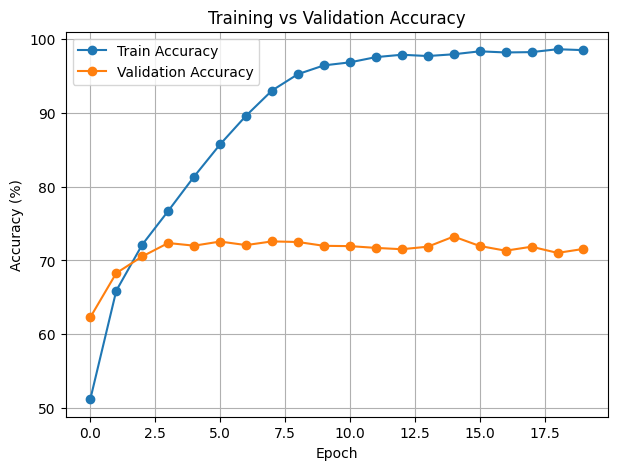

In [43]:
plt.figure(figsize=(7,5))
plt.plot(cnn_metrics["train_acc"], label="Train Accuracy", marker='o')
plt.plot(cnn_metrics["val_acc"], label="Validation Accuracy", marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

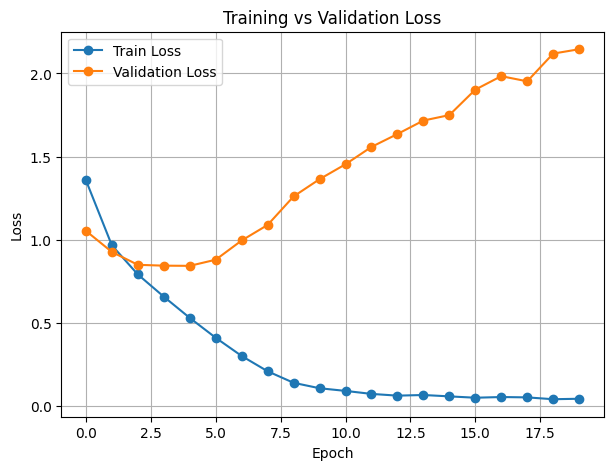

In [44]:
plt.figure(figsize=(7,5))
plt.plot(cnn_metrics["train_loss"], label="Train Loss", marker='o')
plt.plot(cnn_metrics["val_loss"], label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


The final model is again confused by birds, cats and dogs in particular, but not as much as previous models.

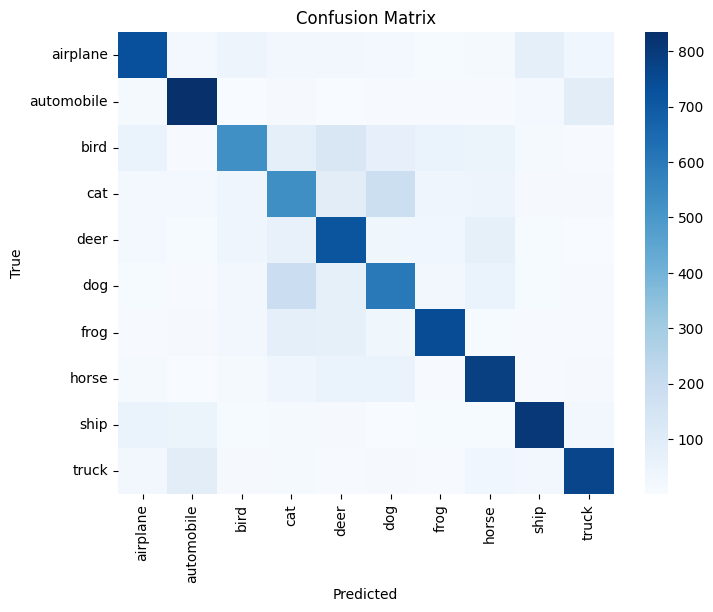

In [45]:
plt.figure(figsize=(8,6))
sns.heatmap(cnn_test_metrics["confusion_matrix"],
            annot=False,
            cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [46]:
print(
    f"accuracy: {cnn_test_metrics['accuracy']}\n"
    f"precision: {cnn_test_metrics['precision']}\n"
    f"recall: {cnn_test_metrics['recall']}\n"
    f"f1: {cnn_test_metrics['f1']}"
)

accuracy: 0.703499972820282
precision: 0.7074882322108957
recall: 0.7035
f1: 0.703380799417818


We can see that there has been a significant improvement in all metrics, increasing the overall accuracy to ~70% nd we can now start to consider how realiable the model is i.e. if it outputs that with 100% confidence, can we believe it?

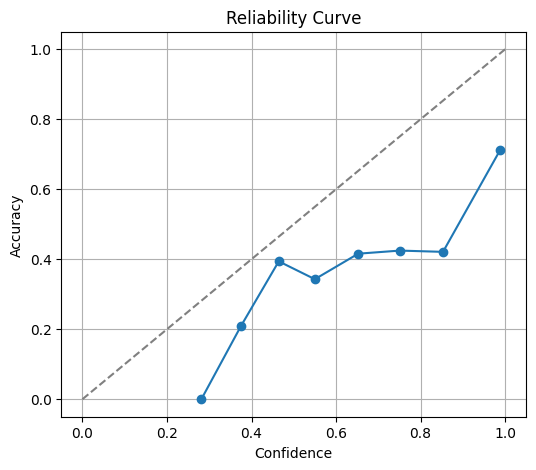

In [47]:
plt.figure(figsize=(6,5))
plt.plot(cnn_test_metrics["reliability_conf"], cnn_test_metrics["reliability_acc"], marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("Reliability Curve")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

The reliability curve is interesting, showing that the model is over confident once again. This overconfidence is worse than the MLP reliability curve. This is a known issue with CNNs, with some researchers suggesting the use of Stochastic Weight Averaging (SWA) [(Cao et al., 2024)](https://www.mdpi.com/2079-9292/13/3/503) or Temperature Scaling [(Guo et al., 2017)](https://arxiv.org/abs/1706.04599) to calibrate the confidence.

### Convolution output

Now that we have trained and tested the model, we can start to look at the why of its decisions. Firstly we can look at the learning output from the convolutional layers.

In [48]:
import matplotlib.pyplot as plt

def visualize_filters(model, layer_name="conv1", num_filters=8):
    layer = getattr(model, layer_name)
    weights = layer.weight.data.cpu()

    fig, axes = plt.subplots(1, num_filters, figsize=(15, 3))
    for i in range(num_filters):
        w = weights[i]
        w = (w - w.min()) / (w.max() - w.min())  # normalize to [0,1]
        axes[i].imshow(w.permute(1, 2, 0))
        axes[i].axis("off")
    plt.suptitle(f"Filters from {layer_name}")
    plt.show()

def visualize_filters_grayscale(model, layer_name="conv2", num_filters=8):
    layer = getattr(model, layer_name)
    weights = layer.weight.data.cpu()

    fig, axes = plt.subplots(num_filters, 4, figsize=(10, num_filters*2))
    for i in range(num_filters):
        for j in range(4):  # show first 4 channels
            w = weights[i, j]  # shape (3,3)
            w = (w - w.min()) / (w.max() - w.min())
            axes[i, j].imshow(w, cmap="gray")
            axes[i, j].axis("off")

    plt.suptitle(f"{layer_name} filters (first 4 channels)")
    plt.show()


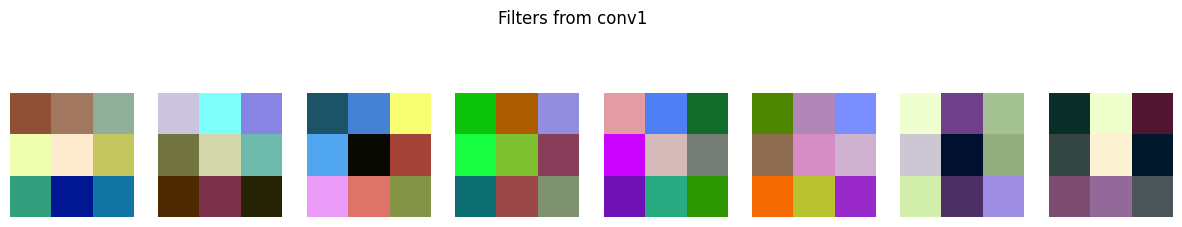

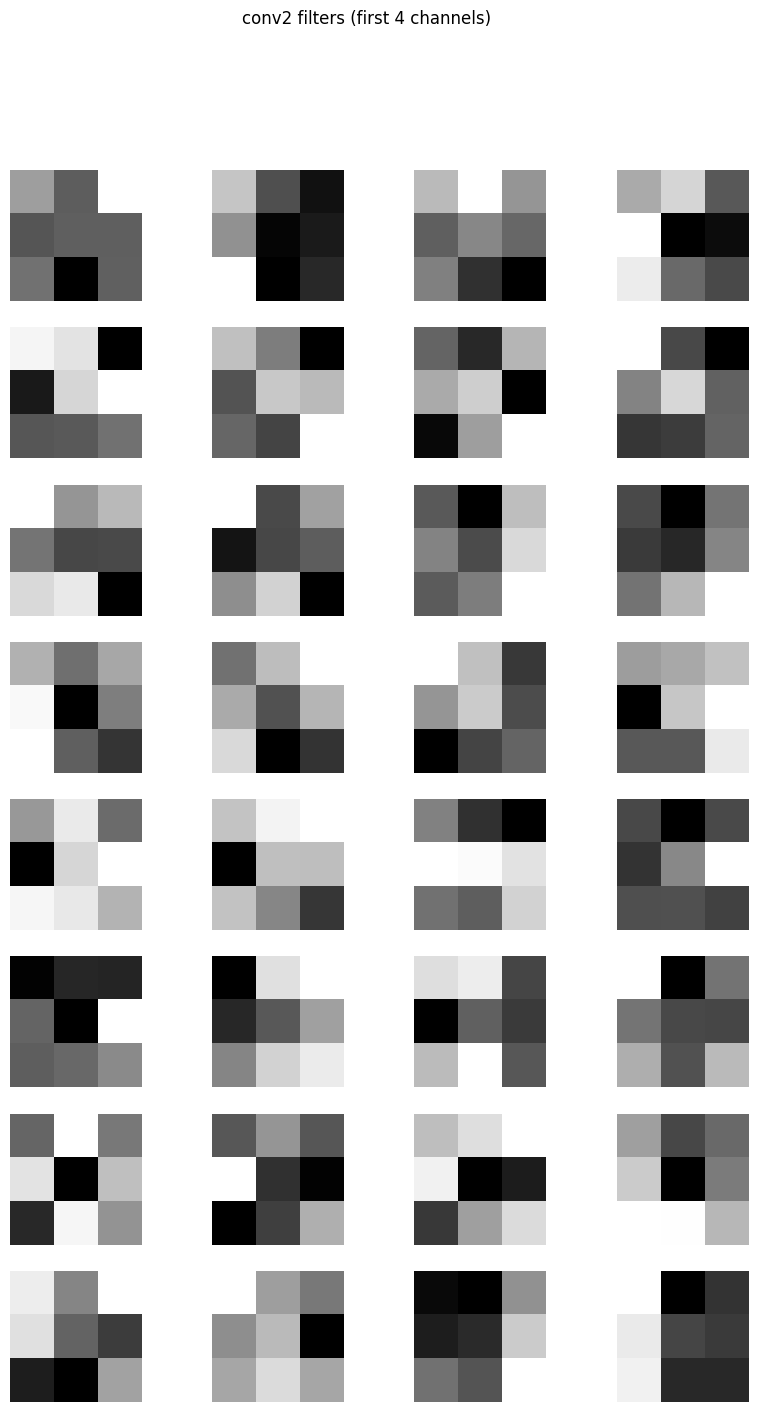

In [12]:
visualize_filters(cnn_best_model, "conv1", num_filters=8)
visualize_filters_grayscale(cnn_best_model, "conv2")


The above shows some of the learnt filters/kernels from the CNN model. The first image shows RGB values, so a red square shows strong positive values of red used in that sqaure. The black and white images are rescaled from multi-dimensional space (conv2 has 32 channels), showing strong positive values as white and strong negative values as black.

We can apply these convolutions to an image to see the feature map outputs.

In [49]:
def visualize_feature_maps(model, image, layer_name="conv1"):
    model.eval()

    device = next(model.parameters()).device
    image = image.to(device)

    layer = getattr(model, layer_name)
    activations = []

    def hook(module, inp, out):
        activations.append(out.detach().cpu())

    handle = layer.register_forward_hook(hook)

    with torch.no_grad():
        _ = model(image.unsqueeze(0))

    handle.remove()

    act = activations[0][0]  # first image in batch

    num_maps = min(8, act.shape[0])
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 3))
    for i in range(num_maps):
        axes[i].imshow(act[i], cmap="viridis")
        axes[i].axis("off")
    plt.suptitle(f"Feature maps from {layer_name}")
    plt.show()


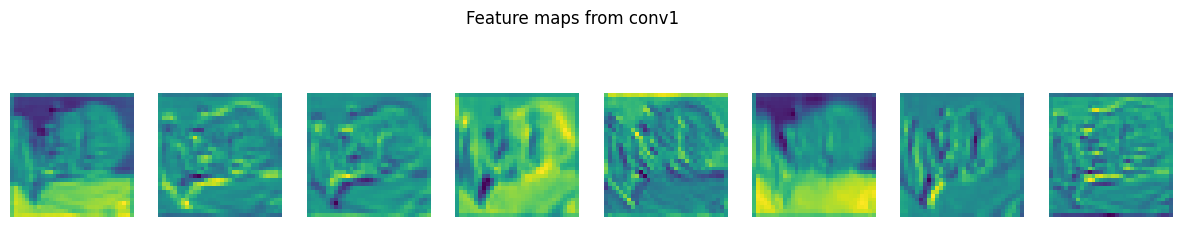

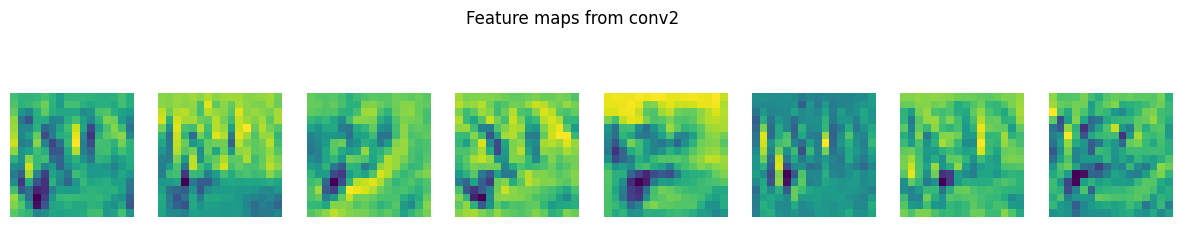

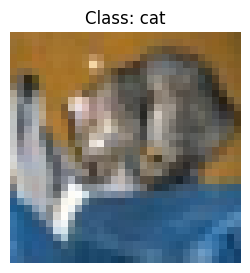

In [50]:
img, _ = next(iter(testloader))
img = img[0]

visualize_feature_maps(cnn_best_model, img, "conv1")
visualize_feature_maps(cnn_best_model, img, "conv2")

img, label = test[0]  
class_name = classes[label] 

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis("off")
plt.title(f"Class: {class_name}")
plt.show()



Here we can see a cat and the convolution maps. Conv1 is likely providing edge detection whereas conv 2 may be looking at texture. Conv1 was particularly useful to me as I was unable to see the cat before looking at these output maps.

### Grad CAM

Gradient-weighted Class Activation Mapped (Grad CAM) is a technique which can show us what parts of the image have contributed most to the models decision [(Selvaraju et al., 2020)](https://arxiv.org/pdf/1610.02391). This is represent as a heat map over the image. We can even break this down to the various different layers of the model.

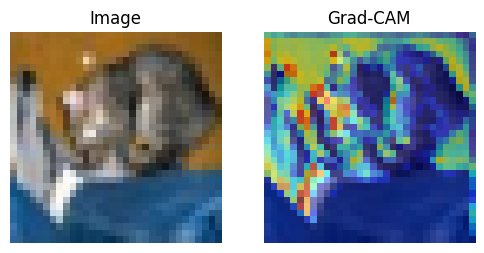

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img, label = next(iter(testloader))
img = img[0]  # shape (3,32,32)
input_tensor = img.unsqueeze(0).to(device)

rgb_img = img.permute(1,2,0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

target_layers = [cnn_best_model.conv1, cnn_best_model.conv2]
cam = GradCAM(model=cnn_best_model, target_layers=target_layers)

with torch.no_grad():
    output = cnn_best_model(input_tensor)
pred_class = output.argmax(dim=1).item()

targets = [ClassifierOutputTarget(pred_class)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(visualization)
plt.title("Grad-CAM")
plt.axis("off")

plt.show()


This seems to be showing activation around the ears and the outline of the cat.

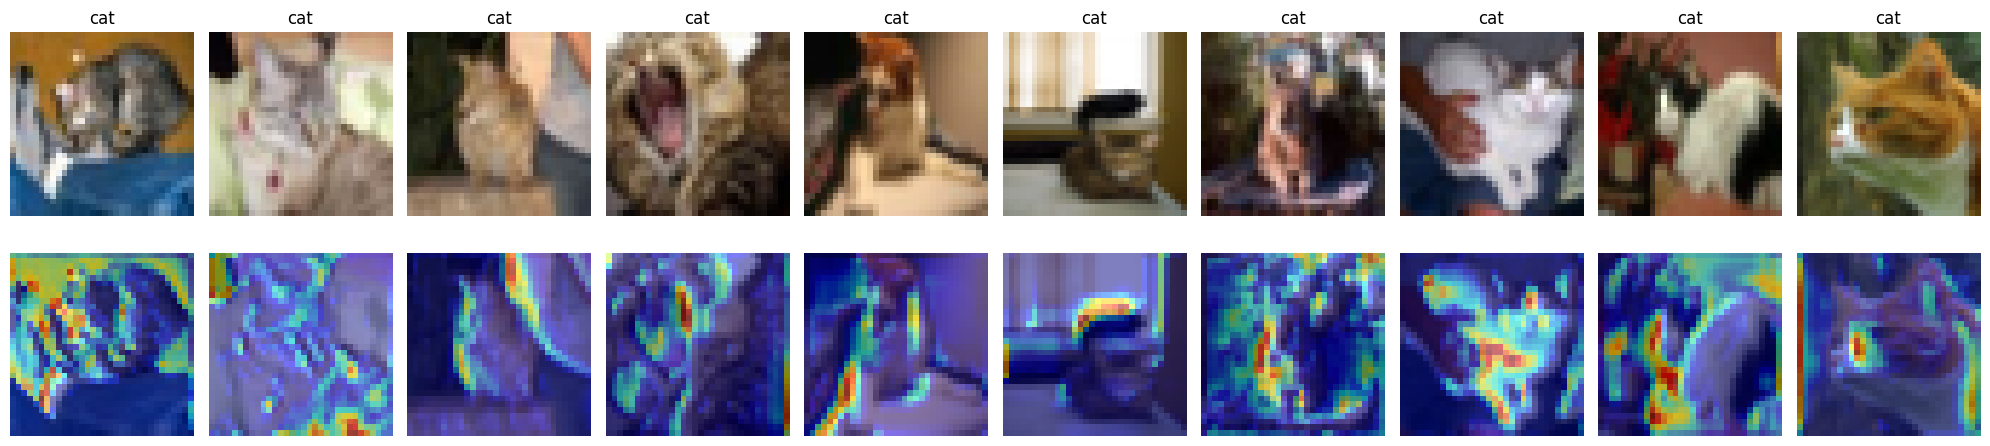

In [7]:
cnn_best_model.eval()

target_class = 3  
num_samples = 10

images = []
for imgs, lbls in testloader:
    for i in range(imgs.size(0)):
        if lbls[i].item() == target_class:
            images.append(imgs[i])
        if len(images) == num_samples:
            break
    if len(images) == num_samples:
        break

target_layers = [cnn_best_model.conv1, cnn_best_model.conv2]
cam_algo = GradCAM(model=cnn_best_model, target_layers=target_layers)

raw_images = []
cam_images = []

for img in images:
    input_tensor = img.unsqueeze(0).to(device)

    # Predict class
    with torch.no_grad():
        pred = cnn_best_model(input_tensor).argmax(dim=1).item()

    # Run CAM
    grayscale_cam = cam_algo(
        input_tensor=input_tensor,
        targets=[ClassifierOutputTarget(pred)]
    )[0]

    # Prepare raw image
    rgb_img = img.permute(1,2,0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # Overlay CAM
    vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    raw_images.append(rgb_img)
    cam_images.append(vis)

plt.figure(figsize=(20, 5))

for i in range(num_samples):
    # Raw image
    plt.subplot(2, num_samples, i+1)
    plt.imshow(raw_images[i])
    plt.title(f"{classes[target_class]}")
    plt.axis("off")

    # Grad-CAM image
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(cam_images[i])
    plt.axis("off")

plt.tight_layout()
plt.show()


The model seems to activate around the face and legs of the cat. How about ships?

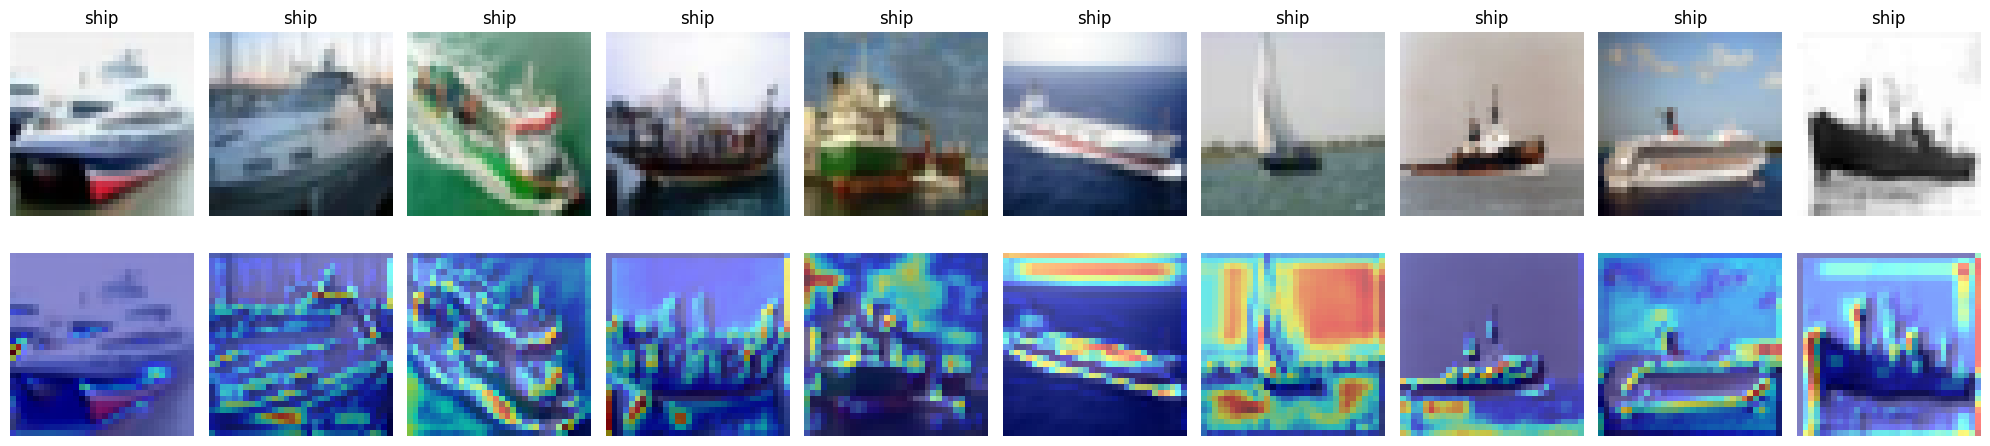

In [8]:
cnn_best_model.eval()

target_class = 8 
num_samples = 10

images = []
for imgs, lbls in testloader:
    for i in range(imgs.size(0)):
        if lbls[i].item() == target_class:
            images.append(imgs[i])
        if len(images) == num_samples:
            break
    if len(images) == num_samples:
        break

target_layers = [cnn_best_model.conv1, cnn_best_model.conv2]
cam_algo = GradCAM(model=cnn_best_model, target_layers=target_layers)

raw_images = []
cam_images = []

for img in images:
    input_tensor = img.unsqueeze(0).to(device)

    # Predict class
    with torch.no_grad():
        pred = cnn_best_model(input_tensor).argmax(dim=1).item()

    # Run CAM
    grayscale_cam = cam_algo(
        input_tensor=input_tensor,
        targets=[ClassifierOutputTarget(pred)]
    )[0]

    # Prepare raw image
    rgb_img = img.permute(1,2,0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # Overlay CAM
    vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    raw_images.append(rgb_img)
    cam_images.append(vis)

plt.figure(figsize=(20, 5))

for i in range(num_samples):
    # Raw image
    plt.subplot(2, num_samples, i+1)
    plt.imshow(raw_images[i])
    plt.title(f"{classes[target_class]}")
    plt.axis("off")

    # Grad-CAM image
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(cam_images[i])
    plt.axis("off")

plt.tight_layout()
plt.show()


The model seems to have identified red banding, sails and the sky as important for ships.

## Pre-trained

There are models available that have been pre-trained to recognise images. Will these outperform our small CNN model?

### ResNet18

Firstly I will run the resnet18 [(He et al., 2015)](https://arxiv.org/abs/1512.03385). This is a pre-trained CNN with the below architecture.

![resnet18 architecture](resnet18_arch.png)

[(Rodrigo Rico Gómez et al., 2024)](https://www.researchgate.net/publication/380665098_An_AI_pipeline_for_garment_price_projection_using_computer_vision)

#### First run - minor fine tune

Resnet18 was not trained on the cifar10 dataset and needs some fine training and transformations of the images to fit well. I dont want to retrain the whole model as I will lose the information that other researchers have gained. This means that I must rescale the images to something closer to the oringial inputs for the model. The cifar10 images are 32x32 and resnet18 was trained on 224x224 so we can rescale cifar10 to 224x224 to best approximate and then keep the learnt behaviour from resnet18. Resnet also expects images to be normalised in a specific way [(www.pytorch.org, n.d.)](https://pytorch.org/hub/pytorch_vision_resnet/).

We're going to try and keep the backbone of this model only tuning the top layers at this point. This tactic of delayed unfreezing helps to preserve the knowledge that was previously learnt [(Slingacademy.com, 2025)](https://www.slingacademy.com/article/advanced-parameter-freezing-techniques-in-pytorch-transfer-learning/). We will continue using the Adam optimiser to update weights, but I've updated the workflow here to include early stopping (as these epochs can take a long time). As we are using early stopping, it doesnt make sense to include a "smooth" scheduler like cosine annealing. This could cause the model to early stop before it has learnt everything it can from the data (as the learning rate may not have changed quickly enough).

![co sine annealing learning rate](cosineannealing_lr.png)

[(PyTorch Contributors, 2025)](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)

Instead, I will use ReduceLROnPlateau. This only reduces the learning rate, but it does this in response to the validation score. As I expect to only fine tune this model, this approach is appropriate.

![reduce lr on plateau scheduler](reducelronplateau.png)

[(PyTorch Contributors, 2023)](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#reducelronplateau)

The workflow has also changed to incorporate some of the more modern aspects of pytorch, in this case the tensorboard, allowing us to read the training and visualise the model in real time.

In [1]:
# run "tensorboard --logdir=runs" in a powershell terminal to view tensorboard

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from datetime import datetime

import torch.profiler  # profiler for op-level graph / trace view

DATA_ROOT = "./data"
CHECKPOINT_DIR = "./checkpoints_resnet18_fine_tune"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

BATCH_SIZE_TRAIN = 128
BATCH_SIZE_EVAL = 128
VAL_SPLIT = 0.1
EPOCHS = 20
PATIENCE = 5
BEST_CKPT_PATH = os.path.join(CHECKPOINT_DIR, "best_model.pth")
LAST_CKPT_PATH = os.path.join(CHECKPOINT_DIR, "last_model.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

trainset_full = torchvision.datasets.CIFAR10(
    root=DATA_ROOT, train=True, download=True, transform=transform
)

num_train = len(trainset_full)
num_val = int(VAL_SPLIT * num_train)
num_train_final = num_train - num_val

trainset, valset = random_split(trainset_full, [num_train_final, num_val])

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE_TRAIN,
                         shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=BATCH_SIZE_EVAL,
                       shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=DATA_ROOT, train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=BATCH_SIZE_EVAL,
                        shuffle=False, num_workers=2)

classes = trainset_full.classes

net = models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)


def final_test(model, testloader, device=None):
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)

            _, pred = torch.max(logits, 1)

            all_preds.append(pred.cpu())
            all_labels.append(labels.cpu())
            all_logits.append(logits.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_logits = torch.cat(all_logits)

    # Metrics
    acc = (all_preds == all_labels).float().mean().item()
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    # Reliability curve
    probs = torch.softmax(all_logits, dim=1)
    conf, pred_class = probs.max(dim=1)
    conf = conf.numpy()
    correct_mask = (pred_class.numpy() == all_labels.numpy())

    bins = 10
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_conf, bin_acc = [], []

    for i in range(bins):
        mask = (conf >= bin_edges[i]) & (conf < bin_edges[i + 1])
        if mask.sum() > 0:
            bin_conf.append(conf[mask].mean())
            bin_acc.append(correct_mask[mask].mean())
        else:
            bin_conf.append((bin_edges[i] + bin_edges[i + 1]) / 2)
            bin_acc.append(np.nan)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "reliability_conf": bin_conf,
        "reliability_acc": bin_acc
    }


# Freeze everything except layer4 + fc
for name, param in net.named_parameters():
    param.requires_grad = ("layer4" in name or "fc" in name)

net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {"params": net.fc.parameters(), "lr": 1e-3},
    {"params": net.layer4.parameters(), "lr": 1e-4}
])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)


def train_eval(model, trainloader, valloader, epochs=EPOCHS, patience=PATIENCE):

    run_name = f"resnet18_fine_tune_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    writer = SummaryWriter(log_dir=f"runs/{run_name}")

    # Log sample images
    dataiter = iter(trainloader)
    sample_images, sample_labels = next(dataiter)
    img_grid = torchvision.utils.make_grid(sample_images[:16])
    writer.add_image("CIFAR10_samples", img_grid)

    # Log model graph
    writer.add_graph(model, sample_images.to(device))

    best_val_loss = float("inf")
    best_epoch = -1
    epochs_no_improve = 0
    best_state = None
    global_step = 0

    # metric histories for plotting
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    # profiler: op-level graph / trace
    with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(
            f"runs/{run_name}/profiler"
        ),
        record_shapes=True,
        with_stack=True,
        profile_memory=True
    ) as prof:

        for epoch in range(1, epochs + 1):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            start_time = time.time()

            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()

                # Log histograms
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        writer.add_histogram(f"Weights/{name}", param.data.cpu(), global_step)
                        writer.add_histogram(f"Grads/{name}", param.grad.cpu(), global_step)

                optimizer.step()

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

                global_step += 1

                # profiler step per batch
                prof.step()

            train_loss = running_loss / len(trainloader)
            train_acc = 100 * correct_train / total_train
            elapsed = time.time() - start_time

            # store train metrics
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)

            model.eval()
            val_running_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    correct_val += (preds == labels).sum().item()
                    total_val += labels.size(0)

            val_loss = val_running_loss / len(valloader)
            val_acc = 100 * correct_val / total_val

            # store val metrics
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)

            scheduler.step(val_loss)

            # TensorBoard scalars
            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("Acc/train", train_acc, epoch)
            writer.add_scalar("Acc/val", val_acc, epoch)
            writer.add_scalar("LR/fc", optimizer.param_groups[0]["lr"], epoch)
            writer.add_scalar("LR/layer4", optimizer.param_groups[1]["lr"], epoch)

            print(f"Epoch {epoch:03d}/{epochs} | "
                  f"TrainLoss {train_loss:.4f} | ValLoss {val_loss:.4f} | "
                  f"TrainAcc {train_acc:.2f}% | ValAcc {val_acc:.2f}% | "
                  f"Time {elapsed:.1f}s")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
                epochs_no_improve = 0
                best_state = {
                    "epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "scheduler_state": scheduler.state_dict(),
                    "val_loss": best_val_loss
                }
                torch.save(best_state, BEST_CKPT_PATH)
                print(f"  -> New best model saved at epoch {epoch}")
            else:
                epochs_no_improve += 1

            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "val_loss": val_loss
            }, LAST_CKPT_PATH)

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    writer.close()

    if best_state is not None:
        model.load_state_dict(best_state["model_state"])

    return {
        "train_loss": train_loss_list,
        "val_loss": val_loss_list,
        "train_acc": train_acc_list,
        "val_acc": val_acc_list,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "best_model": model
    }


train_results = train_eval(net, trainloader, valloader)
best_model = train_results["best_model"]

test_metrics = final_test(best_model, testloader)

torch.save(best_model.state_dict(), os.path.join(CHECKPOINT_DIR, "resnet18_best_weights.pth"))
#best model

Using device: cuda


c:\Users\nexus\Documents\rew\masters\mlai_v2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nexus\Documents\rew\masters\mlai_v2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 001/20 | TrainLoss 0.4504 | ValLoss 0.2827 | TrainAcc 84.56% | ValAcc 90.24% | Time 371.9s
  -> New best model saved at epoch 1
Epoch 002/20 | TrainLoss 0.1386 | ValLoss 0.2814 | TrainAcc 95.46% | ValAcc 90.92% | Time 431.9s
  -> New best model saved at epoch 2
Epoch 003/20 | TrainLoss 0.0343 | ValLoss 0.2984 | TrainAcc 99.14% | ValAcc 91.48% | Time 372.4s
Epoch 004/20 | TrainLoss 0.0105 | ValLoss 0.3284 | TrainAcc 99.79% | ValAcc 91.46% | Time 393.8s
Epoch 005/20 | TrainLoss 0.0047 | ValLoss 0.3458 | TrainAcc 99.94% | ValAcc 91.44% | Time 426.2s
Epoch 006/20 | TrainLoss 0.0019 | ValLoss 0.3396 | TrainAcc 99.99% | ValAcc 91.68% | Time 411.8s
Epoch 007/20 | TrainLoss 0.0012 | ValLoss 0.3425 | TrainAcc 100.00% | ValAcc 91.80% | Time 426.4s
Early stopping at epoch 7


The model stopped training early, but the accuracy appears to be significantly better again. It looks like the training has only improved the model slightly with an accuracy of ~90% on the first epoch.

In [9]:
print(
    f"accuracy: {test_metrics['accuracy']}\n"
    f"precision: {test_metrics['precision']}\n"
    f"recall: {test_metrics['recall']}\n"
    f"f1: {test_metrics['f1']}"
)

accuracy: 0.909500002861023
precision: 0.9095495128924025
recall: 0.9095000000000001
f1: 0.9093534687024153


91% accuracy against unseen data, a massive inporvement over the previous attempts.

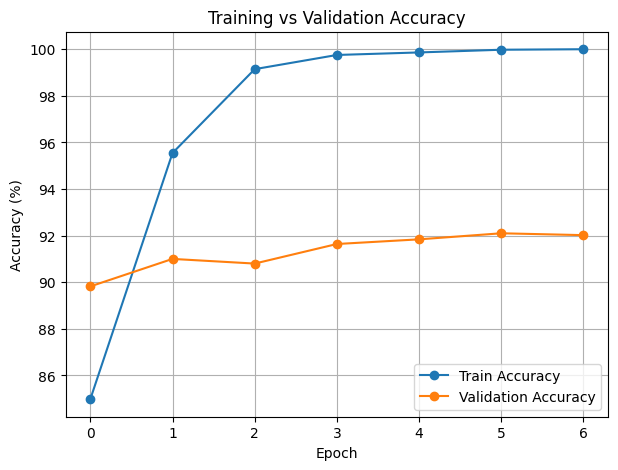

In [10]:
plt.figure(figsize=(7,5))
plt.plot(train_results["train_acc"], label="Train Accuracy", marker='o')
plt.plot(train_results["val_acc"], label="Validation Accuracy", marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

We can again see evidence of overfit, the training accuracy is significantly higher than the validation accuracy.

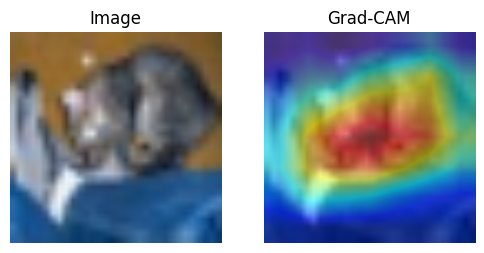

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img, label = next(iter(testloader))
img = img[0]  # shape (3,32,32)
input_tensor = img.unsqueeze(0).to(device)

rgb_img = img.permute(1,2,0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

target_layers = [best_model.layer4[-1].conv2]
cam = GradCAM(model=best_model, target_layers=target_layers)

with torch.no_grad():
    output = best_model(input_tensor)
pred_class = output.argmax(dim=1).item()

targets = [ClassifierOutputTarget(pred_class)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(visualization)
plt.title("Grad-CAM")
plt.axis("off")

plt.show()


The Grad-CAM image shows that the models attention is heavily centered on the cat.

#### Full train

We've seen the performance of a minor fine tune to the head only. Previously we have only fine tuned the model. As a full tune is a more involved process. I have made a few changes. These changes also seek to address a major probem that we have observed with CNN architecture, overfit.

##### Changes to workflow

* Firstly the training and validation sets are stratified to ensure that they are balanced during training, giving the model the best chance to understand the differences in classes for both training and validation in each epoch. 
* I have started a small warm up process, which seeks to train the head only for a short period. This is effective in controlling adaptation (i.e. the model is training too much at once) and helps transfer learning.
* I have implimented a few regularisation methods to help prevent over fitting.
    * The first is label smoothing. This ensures that there is some small degree of ambiguity baked into all training images, forcing the model to consider the outcome more deeply.
    * The second is augmentation, specifically cutmix and mixup. These techniques make changes to the training images, rotating and chopping them up, effectively providing a larger and more diverse training set. Specifically I have allowed 80% of images to be augmented in some way, and that of these mixed up images, 80% have mixup applied and 20% have cutmix applied. Cutmix is a more aggressive method so reducing the amount of images that have this applied appears to help the model.
    ![cutmix and mix up methodologies](cutmix.png)

        [(Tsang, 2020)](https://sh-tsang.medium.com/paper-cutmix-regularization-strategy-to-train-strong-classifiers-with-localizable-features-5527e29c4890)
* In response to the above changes, we are now using soft targets (target probability distributions produced by cutmix/mixup and label smoothing) instead of hard targets (distinct classes) during training. This has required a change to the validation assessment, and validation loss is now being used instead of validation accuracy. Loss assesses how wrong the model is (for instance saying that the image is 90% a cat when it's a dog is more wrong than saying the image is 70% cat when it's a dog).
* I have implimented early stopping. If the model is no long getting any better, it will stop after a specific number of epochs, saving time.
* The scheduler has changed to onecyclelr

![one cycle lr](onecyclelr.png)

[(Pytorch.org, 2024)](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html)

This scheduler promotes warming up, a deep search of the problem and a final refinement [(Smith and Topin, 2018)](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html).
* I've used gradient clipping to prevent gradient explosions, reducing the chance of the model being destabilised during training, particularly with the large learning rates allowed by the onecyclelr scheduler and EMA.
* I've used Exponential Moving Average (EMA) which essentially acts like a memory of changes, allowing better generalisation and smooths noisy updates [(Morales-Brotons, Vogels and Hendrikx, 2024)](https://arxiv.org/abs/2411.18704). It is this smoothed model which is used in validation and as the final model.
* Finally I've used temperature scaling to calibrate the models confidence. Though I will discuss this further, later.

In [ ]:
# run "tensorboard --logdir=runs" in a terminal to view tensorboard

import os
import time
import math
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.models as models

from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.swa_utils import AveragedModel
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from datetime import datetime

# -----------------------------
# CONFIG
# -----------------------------
DATA_ROOT = "./data"
CHECKPOINT_DIR = "./checkpoints_resnet18_full_tune"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

BATCH_SIZE_TRAIN = 128
BATCH_SIZE_EVAL = 128
VAL_SPLIT = 0.1

WARMUP_EPOCHS = 5
MAIN_EPOCHS = 20
TOTAL_EPOCHS = WARMUP_EPOCHS + MAIN_EPOCHS

PATIENCE = 5
BEST_CKPT_PATH = os.path.join(CHECKPOINT_DIR, "best_model.pth")
LAST_CKPT_PATH = os.path.join(CHECKPOINT_DIR, "last_model.pth")

BASE_LR = 1e-3
BACKBONE_LR_SCALE = 0.1
WEIGHT_DECAY = 1e-3

LABEL_SMOOTHING = 0.1
EMA_DECAY = 0.999
GRAD_CLIP_NORM = 1.0

# Augmentation config
AUG_PROB = 0.80          # % of batches that get augmented
MIXUP_FRACTION = 0.80    # % of augmented batches that use MixUp
CUTMIX_FRACTION = 0.20   # % of augmented batches that use CutMix

MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# DATA
# -----------------------------
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

trainset_full = torchvision.datasets.CIFAR10(
    root=DATA_ROOT, train=True, download=True, transform=transform
)

targets = np.array(trainset_full.targets)
sss = StratifiedShuffleSplit(
    n_splits=1, test_size=VAL_SPLIT, random_state=42
)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

trainset = Subset(trainset_full, train_idx)
valset = Subset(trainset_full, val_idx)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE_TRAIN,
                         shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=BATCH_SIZE_EVAL,
                       shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root=DATA_ROOT, train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=BATCH_SIZE_EVAL,
                        shuffle=False, num_workers=2)

classes = trainset_full.classes

# -----------------------------
# MODEL
# -----------------------------
net = models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

# -----------------------------
# MIXUP / CUTMIX (Torchvision v2)
# -----------------------------
mixup = v2.MixUp(num_classes=10, alpha=MIXUP_ALPHA)
cutmix = v2.CutMix(num_classes=10, alpha=CUTMIX_ALPHA)

def apply_mix(inputs, labels):
    # Only augment AUG_PROB of the time
    if torch.rand(1).item() > AUG_PROB:
        return inputs, labels

    # Choose MixUp vs CutMix based on fractions
    r = torch.rand(1).item()
    if r < MIXUP_FRACTION:
        return mixup(inputs, labels)
    else:
        return cutmix(inputs, labels)

# -----------------------------
# LOSS (label smoothing)
# -----------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

# -----------------------------
# CALIBRATION HELPERS
# -----------------------------
def compute_ece(probs, labels, n_bins=15):

    probs = probs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        lo = bin_edges[i]
        hi = bin_edges[i + 1]
        mask = (confidences > lo) & (confidences <= hi)
        if not np.any(mask):
            continue
        bin_conf = confidences[mask].mean()
        bin_acc = (predictions[mask] == labels[mask]).mean()
        ece += np.abs(bin_acc - bin_conf) * (mask.sum() / len(labels))

    return ece

def collect_logits_and_labels(model, dataloader, device):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            logits = model(inputs)
            all_logits.append(logits)
            all_labels.append(labels)
    return torch.cat(all_logits), torch.cat(all_labels)

def fit_temperature(model, valloader, device):
    logits, labels = collect_logits_and_labels(model, valloader, device)
    nll_criterion = nn.CrossEntropyLoss().to(device)

    T = torch.ones(1, device=device, requires_grad=True)
    optimizer = optim.LBFGS([T], lr=0.1, max_iter=50)

    def _eval():
        optimizer.zero_grad()
        scaled_logits = logits / T
        loss = nll_criterion(scaled_logits, labels)
        loss.backward()
        return loss

    optimizer.step(_eval)
    return T.detach()

def evaluate_model(model, dataloader, device, temperature=None):

    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            logits = model(inputs)
            all_logits.append(logits)
            all_labels.append(labels)

    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    if temperature is not None:
        all_logits = all_logits / temperature

    probs = torch.softmax(all_logits, dim=1)
    conf, preds = probs.max(dim=1)

    acc = (preds == all_labels).float().mean().item()
    prec = precision_score(all_labels.cpu(), preds.cpu(), average='macro')
    rec = recall_score(all_labels.cpu(), preds.cpu(), average='macro')
    f1 = f1_score(all_labels.cpu(), preds.cpu(), average='macro')
    cm = confusion_matrix(all_labels.cpu(), preds.cpu())

    ece = compute_ece(probs, all_labels, n_bins=15)

    # reliability curve data
    conf_np = conf.cpu().numpy()
    correct_np = (preds == all_labels).cpu().numpy()
    bins = 10
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_conf, bin_acc = [], []

    for i in range(bins):
        mask = (conf_np >= bin_edges[i]) & (conf_np < bin_edges[i + 1])
        if mask.sum() > 0:
            bin_conf.append(conf_np[mask].mean())
            bin_acc.append(correct_np[mask].mean())
        else:
            bin_conf.append((bin_edges[i] + bin_edges[i + 1]) / 2)
            bin_acc.append(np.nan)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "ece": ece,
        "reliability_conf": bin_conf,
        "reliability_acc": bin_acc
    }

# -----------------------------
# TRAINING (WARMUP + MAIN)
# -----------------------------
def train_eval(runname, model, trainloader, valloader,
               warmup_epochs=WARMUP_EPOCHS,
               main_epochs=MAIN_EPOCHS,
               patience=PATIENCE):

    model = model.to(device)

    # metric histories
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    run_name = f"{runname}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    writer = SummaryWriter(log_dir=f"runs/{run_name}")

    # sample images + graph
    dataiter = iter(trainloader)
    sample_images, sample_labels = next(dataiter)
    img_grid = torchvision.utils.make_grid(sample_images[:16])
    writer.add_image("CIFAR10_samples", img_grid)
    writer.add_graph(model, sample_images.to(device))

    # -----------------------------
    # WARMUP PHASE (HEAD ONLY)
    # -----------------------------
    for name, param in model.named_parameters():
        param.requires_grad = ("fc" in name)

    head_params = [p for n, p in model.named_parameters() if p.requires_grad]
    optimizer = optim.AdamW(head_params, lr=BASE_LR, weight_decay=WEIGHT_DECAY)

    ema = AveragedModel(model, avg_fn=lambda avg, new, _: EMA_DECAY * avg + (1 - EMA_DECAY) * new)

    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0
    global_step = 0

    print(f"\n=== Warmup phase: {warmup_epochs} epochs (head only) ===\n")
    for epoch in range(1, warmup_epochs + 1):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(head_params, GRAD_CLIP_NORM)
            optimizer.step()

            ema.update_parameters(model)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            global_step += 1

        # EMA validation
        eval_model = ema.module
        eval_model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = eval_model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct_val / total_val
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct_train / total_train
        elapsed = time.time() - start_time

        # store metrics
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(
            f"[Warmup] Epoch {epoch}/{warmup_epochs} | "
            f"TrainLoss {train_loss:.4f} | TrainAcc {train_acc:.2f}% | "
            f"ValLoss {val_loss:.4f} | ValAcc {val_acc:.2f}% | "
            f"Time {elapsed:.1f}s"
        )

    # -----------------------------
    # MAIN TRAINING PHASE
    # -----------------------------
    print(f"\n=== Main phase: unfreeze + OneCycleLR for {main_epochs} epochs ===\n")

    for param in model.parameters():
        param.requires_grad = True

    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if "fc" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = optim.AdamW([
        {"params": head_params, "lr": BASE_LR},
        {"params": backbone_params, "lr": BASE_LR * BACKBONE_LR_SCALE}
    ], weight_decay=WEIGHT_DECAY)

    steps_per_epoch = len(trainloader)
    total_steps = main_epochs * steps_per_epoch

    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[BASE_LR, BASE_LR * BACKBONE_LR_SCALE],
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos'
    )

    for epoch_idx in range(main_epochs):
        epoch = warmup_epochs + epoch_idx + 1
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp/CutMix with AUG_PROB
            inputs_mixed, targets_mixed = apply_mix(inputs, labels)

            optimizer.zero_grad()

            outputs = model(inputs_mixed)
            loss = criterion(outputs, targets_mixed)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            optimizer.step()
            scheduler.step()

            ema.update_parameters(model)

            running_loss += loss.item()

            # accuracy uses clean labels
            with torch.no_grad():
                clean_outputs = model(inputs)
                _, preds = torch.max(clean_outputs, 1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            global_step += 1

        # EMA validation
        eval_model = ema.module
        eval_model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = eval_model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct_val / total_val
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct_train / total_train
        elapsed = time.time() - start_time

        # store metrics
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(
            f"[Main] Epoch {epoch}/{TOTAL_EPOCHS} | "
            f"TrainLoss {train_loss:.4f} | TrainAcc {train_acc:.2f}% | "
            f"ValLoss {val_loss:.4f} | ValAcc {val_acc:.2f}% | "
            f"Time {elapsed:.1f}s"
        )

        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {
                "epoch": epoch,
                "model_state": eval_model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "val_loss": best_val_loss
            }
            torch.save(best_state, BEST_CKPT_PATH)
            print(f"  -> New best EMA model saved at epoch {epoch}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        torch.save({
            "epoch": epoch,
            "model_state": eval_model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "val_loss": val_loss
        }, LAST_CKPT_PATH)

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    writer.close()

    if best_state is not None:
        model.load_state_dict(best_state["model_state"])

    return {
        "train_loss": train_loss_list,
        "val_loss": val_loss_list,
        "train_acc": train_acc_list,
        "val_acc": val_acc_list,
        "best_model": model
    }


    # -----------------------------
    # MAIN TRAINING PHASE
    # -----------------------------
    print(f"\n=== Main phase: unfreeze + OneCycleLR for {main_epochs} epochs ===\n")

    for param in model.parameters():
        param.requires_grad = True

    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if "fc" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = optim.AdamW([
        {"params": head_params, "lr": BASE_LR},
        {"params": backbone_params, "lr": BASE_LR * BACKBONE_LR_SCALE}
    ], weight_decay=WEIGHT_DECAY)

    steps_per_epoch = len(trainloader)
    total_steps = main_epochs * steps_per_epoch

    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[BASE_LR, BASE_LR * BACKBONE_LR_SCALE],
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos'
    )

    for epoch_idx in range(main_epochs):
        epoch = warmup_epochs + epoch_idx + 1
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp/CutMix with AUG_PROB
            inputs_mixed, targets_mixed = apply_mix(inputs, labels)

            optimizer.zero_grad()

            outputs = model(inputs_mixed)
            loss = criterion(outputs, targets_mixed)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            optimizer.step()
            scheduler.step()

            ema.update_parameters(model)

            running_loss += loss.item()

            # accuracy uses clean labels
            with torch.no_grad():
                clean_outputs = model(inputs)
                _, preds = torch.max(clean_outputs, 1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            global_step += 1

        # EMA validation
        eval_model = ema.module
        eval_model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = eval_model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct_val / total_val
        train_acc = 100 * correct_train / total_train
        elapsed = time.time() - start_time

        print(
            f"[Main] Epoch {epoch}/{TOTAL_EPOCHS} | "
            f"TrainLoss {running_loss/len(trainloader):.4f} | "
            f"TrainAcc {train_acc:.2f}% | "
            f"ValLoss {val_loss:.4f} | ValAcc {val_acc:.2f}% | "
            f"Time {elapsed:.1f}s"
        )

        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {
                "epoch": epoch,
                "model_state": eval_model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "val_loss": best_val_loss
            }
            torch.save(best_state, BEST_CKPT_PATH)
            print(f"  -> New best EMA model saved at epoch {epoch}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        torch.save({
            "epoch": epoch,
            "model_state": eval_model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "val_loss": val_loss
        }, LAST_CKPT_PATH)

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    writer.close()

    if best_state is not None:
        model.load_state_dict(best_state["model_state"])

    return {
        "best_model": model
    }

# -----------------------------
# RUN TRAINING + TEMPERATURE SCALING + TEST
# -----------------------------
train_results = train_eval("resnet18_cifar10_full", net, trainloader, valloader)
best_model = train_results["best_model"]

print("\nFitting temperature on validation set (EMA model)...")
T = fit_temperature(best_model, valloader, device)
print(f"Learned temperature: {T.item():.4f}")

test_metrics_uncal = evaluate_model(best_model, testloader, device, temperature=None)

test_metrics_cal = evaluate_model(best_model, testloader, device, temperature=T)

# save model and temperature separately
torch.save(best_model.state_dict(), os.path.join(CHECKPOINT_DIR, "resnet18_best_weights.pth"))
torch.save(T, os.path.join(CHECKPOINT_DIR, "temperature.pt"))


Using device: cuda


c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nexus\Documents\rew\masters\mlai\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Warmup phase: 5 epochs (head only) ===

[Warmup] Epoch 1/5 | TrainLoss 1.2016 | TrainAcc 71.95% | ValLoss 1.7487 | ValAcc 54.26% | Time 172.5s
[Warmup] Epoch 2/5 | TrainLoss 1.0291 | TrainAcc 79.08% | ValLoss 1.3214 | ValAcc 74.42% | Time 159.6s
[Warmup] Epoch 3/5 | TrainLoss 1.0095 | TrainAcc 80.19% | ValLoss 1.1324 | ValAcc 78.80% | Time 160.5s
[Warmup] Epoch 4/5 | TrainLoss 1.0015 | TrainAcc 80.61% | ValLoss 1.0501 | ValAcc 80.08% | Time 159.9s
[Warmup] Epoch 5/5 | TrainLoss 0.9964 | TrainAcc 80.68% | ValLoss 1.0095 | ValAcc 80.76% | Time 156.0s

=== Main phase: unfreeze + OneCycleLR for 20 epochs ===

[Main] Epoch 6/25 | TrainLoss 1.2102 | TrainAcc 84.76% | ValLoss 1.0300 | ValAcc 79.36% | Time 1023.7s
  -> New best EMA model saved at epoch 6
[Main] Epoch 7/25 | TrainLoss 1.0879 | TrainAcc 90.96% | ValLoss 1.0952 | ValAcc 74.98% | Time 1024.4s
[Main] Epoch 8/25 | TrainLoss 0.9758 | TrainAcc 95.62% | ValLoss 1.0369 | ValAcc 77.72% | Time 1030.0s
[Main] Epoch 9/25 | TrainLoss 0.

Looks like this is quite close to being optimised, with validation and test climbing together nicely. It does look like we are still tending towards over fit though with the training accuracy hitting 100%.

In [32]:
print(
    f"accuracy: {test_metrics_uncal['accuracy']}\n"
    f"precision: {test_metrics_uncal['precision']}\n"
    f"recall: {test_metrics_uncal['recall']}\n"
    f"f1: {test_metrics_uncal['f1']}"
)

accuracy: 0.9620999693870544
precision: 0.9620474550080594
recall: 0.9621000000000001
f1: 0.9620216043230136


>96% accuracy is now over my expectations. 93% is supposed to be around human accuracy so this model may now be more accurate than I am.

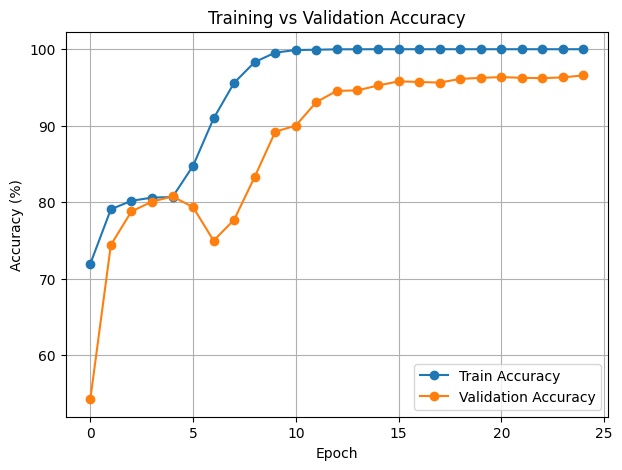

In [16]:
plt.figure(figsize=(7,5))
plt.plot(train_results["train_acc"], label="Train Accuracy", marker='o')
plt.plot(train_results["val_acc"], label="Validation Accuracy", marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

Validation accuracy is still climbing after 20 epochs. Likely we could add more epochs this to improve the model more.

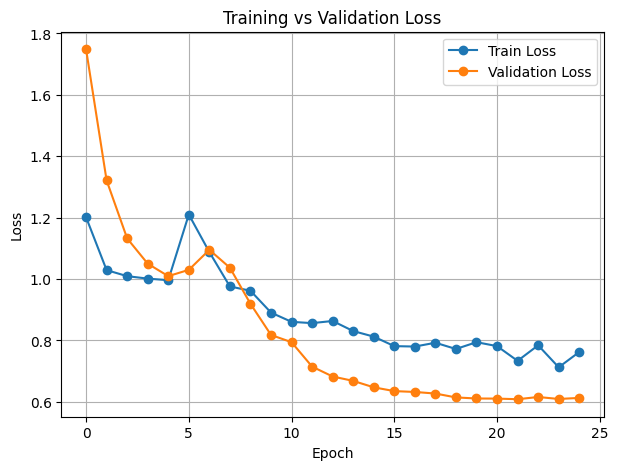

In [19]:
plt.figure(figsize=(7,5))
plt.plot(train_results["train_loss"], label="Train Loss", marker='o')
plt.plot(train_results["val_loss"], label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


Validation loss appears fairly stable after 20 epochs.

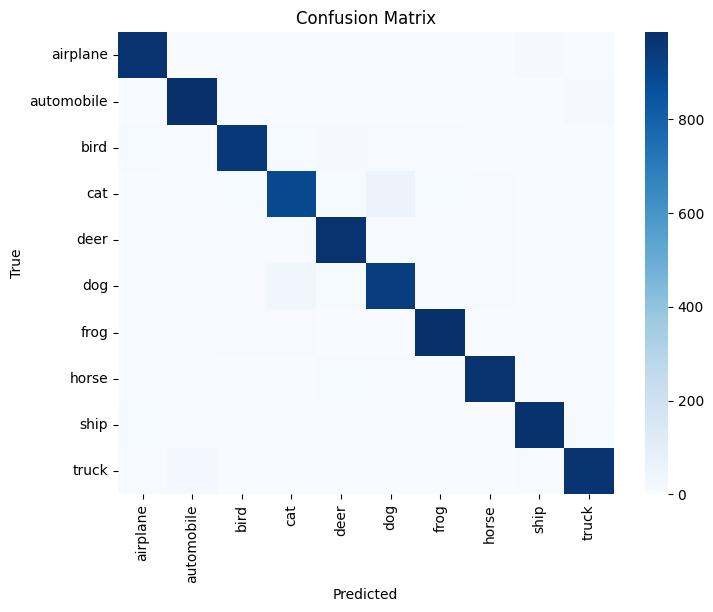

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(test_metrics_uncal["confusion_matrix"],
            annot=False,
            cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Again its cats and dogs which appear to be the hardest to classify.

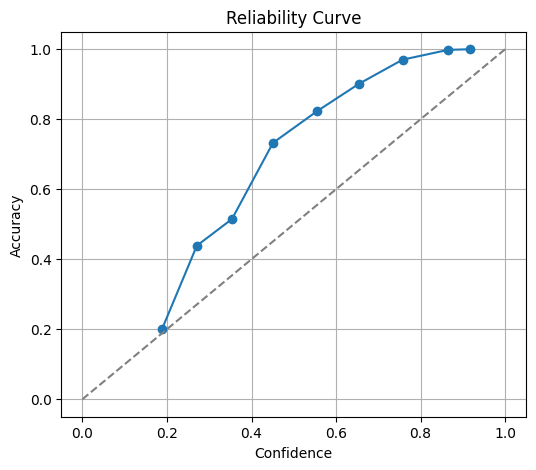

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(test_metrics_uncal["reliability_conf"], test_metrics_uncal["reliability_acc"], marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("Reliability Curve - uncalibrated")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

The model appears to be underconfident, which is suprising but probably caused by the heavy regularisation strategy I have used. However, for later methods (knowledge distillation and cascaded inference), it's best that this confidence issue is calibrated. For this I will use temperature scaling [(Guo et al., 2017)](https://arxiv.org/abs/1706.04599).

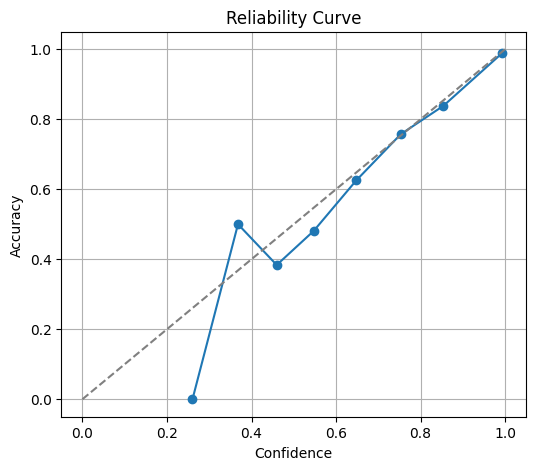

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(test_metrics_cal["reliability_conf"], test_metrics_cal["reliability_acc"], marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("Reliability Curve - calibrated")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

Using this techniqu, we can see that the confidence is nearly exactly calibrated.

In [25]:
print("Uncalibrated ECE:", test_metrics_uncal["ece"])
print("Calibrated ECE:", test_metrics_cal["ece"])

Uncalibrated ECE: 0.14557613718807694
Calibrated ECE: 0.006979272879660176


And that the Expected Calibration Error (ECE) is now nearly at 0. The model had a 0.14 point difference between its confidence and actual accuracy. We can look at the GRAD-CAM images to investigate why the model is making its decision.

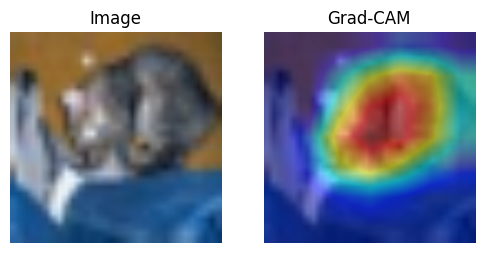

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img, label = next(iter(testloader))
img = img[0]  # shape (3,32,32)
input_tensor = img.unsqueeze(0).to(device)

rgb_img = img.permute(1,2,0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

target_layers = [best_model.layer4[-1].conv2]
cam = GradCAM(model=best_model, target_layers=target_layers)

with torch.no_grad():
    output = best_model(input_tensor)
pred_class = output.argmax(dim=1).item()

targets = [ClassifierOutputTarget(pred_class)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(visualization)
plt.title("Grad-CAM")
plt.axis("off")

plt.show()


So it's definitely identified the cat. Which images did it misclassify? 

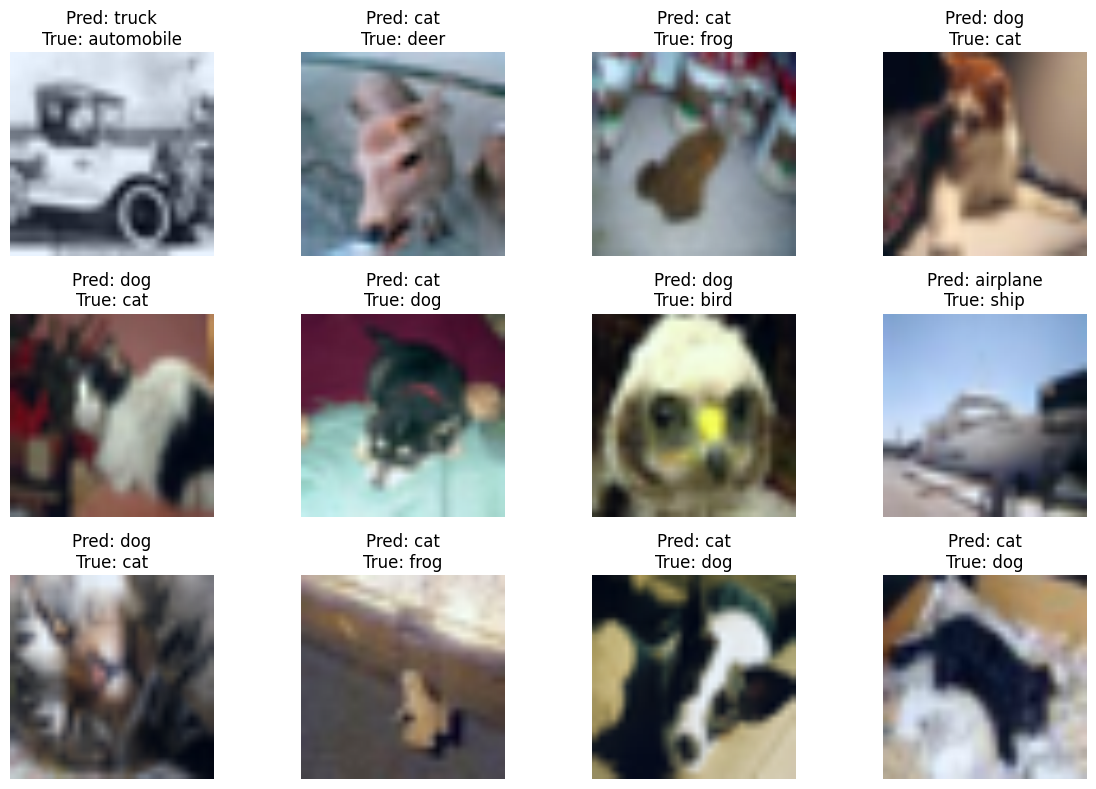

In [27]:
misclassified = []

best_model.eval()
with torch.no_grad():
    for imgs, labels in testloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        preds = best_model(imgs).argmax(dim=1)
        wrong = preds != labels

        for img, p, t in zip(imgs[wrong], preds[wrong], labels[wrong]):
            misclassified.append((img.cpu(), int(p), int(t)))

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

for i, (img, pred, true) in enumerate(misclassified[:12]):
    img_np = img.permute(1,2,0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    plt.subplot(3, 4, i+1)
    plt.imshow(img_np)
    plt.title(f"Pred: {testset.classes[pred]}\nTrue: {testset.classes[true]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


To be fair on the model, I can understand why a lot of these are miss classified. Lets take a look at why it may hace miss classified the deer image.

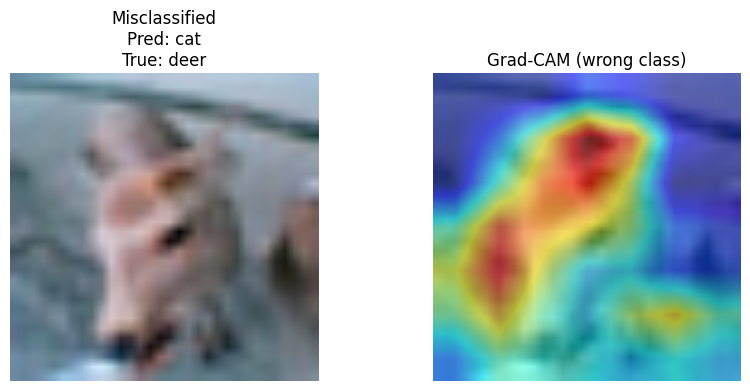

In [ ]:
img, pred, true = misclassified[1]

input_tensor = img.unsqueeze(0).to(device)

rgb_img = img.permute(1,2,0).numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [best_model.layer4[-1].conv2]
cam = GradCAM(model=best_model, target_layers=target_layers)

with torch.no_grad():
    output = best_model(input_tensor)

targets = [ClassifierOutputTarget(pred)]   # use the WRONG predicted class

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title(f"Misclassified\nPred: {testset.classes[pred]}\nTrue: {testset.classes[true]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cam_image)
plt.title("Grad-CAM (wrong class)")
plt.axis("off")

plt.show()


Theres a large activation to the back of the deer and the ground to the left of the image. We can also activation around its legs and a shadow or some change in the ground which looks like 3 legs. We can dive a little further and look at the various convolutional layers of resnet18 to see how they activated.

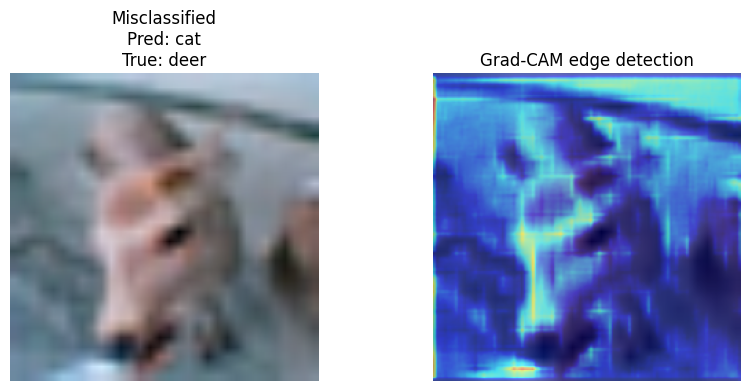

In [ ]:
target_layers = [best_model.conv1]
cam = GradCAMPlusPlus(model=best_model, target_layers=target_layers)

with torch.no_grad():
    output = best_model(input_tensor)

targets = [ClassifierOutputTarget(pred)]   # use the WRONG predicted class

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title(f"Misclassified\nPred: {testset.classes[pred]}\nTrue: {testset.classes[true]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cam_image)
plt.title("Grad-CAM edge detection")
plt.axis("off")

plt.show()


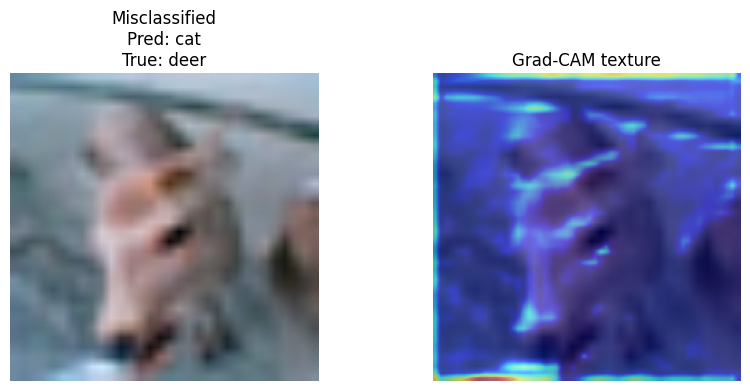

In [ ]:
target_layers = [best_model.layer1[0].conv1]

cam = GradCAMPlusPlus(model=best_model, target_layers=target_layers)

with torch.no_grad():
    output = best_model(input_tensor)

targets = [ClassifierOutputTarget(pred)]   # use the WRONG predicted class

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title(f"Misclassified\nPred: {testset.classes[pred]}\nTrue: {testset.classes[true]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cam_image)
plt.title("Grad-CAM texture")
plt.axis("off")

plt.show()


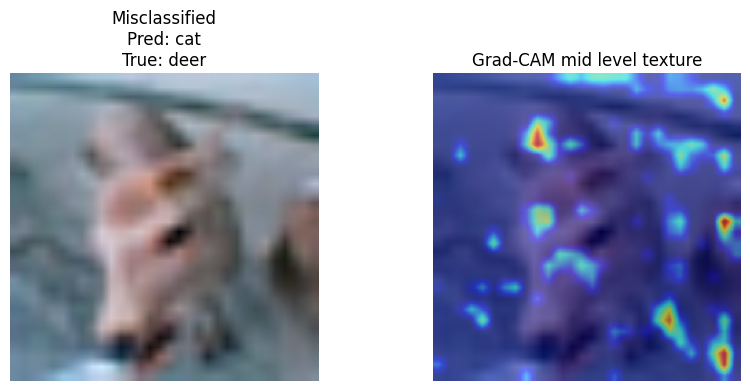

In [ ]:
target_layers = [best_model.layer2[-1].conv2]

cam = GradCAM(model=best_model, target_layers=target_layers)

with torch.no_grad():
    output = best_model(input_tensor)

targets = [ClassifierOutputTarget(pred)] 

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title(f"Misclassified\nPred: {testset.classes[pred]}\nTrue: {testset.classes[true]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cam_image)
plt.title("Grad-CAM mid level texture")
plt.axis("off")

plt.show()


Ultimately, we may be nearing the limit of the data set. At 32x32 there may just not be much more data to pull out of the image.

## ResNet50
ResNet18 has 18 layers and it uses BasicBlocks (each block has two convlutional layers) resulting in ~11 million parameters. ResNet 50 uses BottleneckBlocks (each block has three convultional layers) resulting in ~25 million parameters. This is more than double the amount of tuneable parameters and as such will take substantially longer to train and requires a change in computation. The model is so large, that my GPU struggles to handle it. As such, I've had to push the processing, in part, to the CPU.

In [ ]:
# run "tensorboard --logdir=runs" in a terminal to view tensorboard

import os
import time
import math
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.models as models

from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.swa_utils import AveragedModel
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from datetime import datetime

# -----------------------------
# CONFIG
# -----------------------------
DATA_ROOT = "./data"
CHECKPOINT_DIR = "./checkpoints_resnet50_full_tune"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_EVAL = 8
VAL_SPLIT = 0.1

WARMUP_EPOCHS = 10
MAIN_EPOCHS = 20
TOTAL_EPOCHS = WARMUP_EPOCHS + MAIN_EPOCHS

PATIENCE = 5
BEST_CKPT_PATH = os.path.join(CHECKPOINT_DIR, "best_model.pth")
LAST_CKPT_PATH = os.path.join(CHECKPOINT_DIR, "last_model.pth")

BASE_LR = 1e-3
BACKBONE_LR_SCALE = 0.1
WEIGHT_DECAY = 1e-3

LABEL_SMOOTHING = 0.1
EMA_DECAY = 0.999
GRAD_CLIP_NORM = 1.0

# Augmentation config
AUG_PROB = 0.80          # % of batches that get augmented
MIXUP_FRACTION = 0.80    # % of augmented batches that use MixUp
CUTMIX_FRACTION = 0.20   # % of augmented batches that use CutMix

MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# DATA
# -----------------------------
transform = transforms.Compose([
    transforms.Resize(160),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

trainset_full = torchvision.datasets.CIFAR10(
    root=DATA_ROOT, train=True, download=True, transform=transform
)

targets = np.array(trainset_full.targets)
sss = StratifiedShuffleSplit(
    n_splits=1, test_size=VAL_SPLIT, random_state=42
)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

trainset = Subset(trainset_full, train_idx)
valset = Subset(trainset_full, val_idx)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE_TRAIN,
                         shuffle=True, num_workers=1, pin_memory=False
)
valloader = DataLoader(valset, batch_size=BATCH_SIZE_EVAL,
                       shuffle=False, num_workers=1, pin_memory=False
)

testset = torchvision.datasets.CIFAR10(
    root=DATA_ROOT, train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=BATCH_SIZE_EVAL,
                        shuffle=False, num_workers=1)

classes = trainset_full.classes

mixup = v2.MixUp(num_classes=10, alpha=MIXUP_ALPHA)
cutmix = v2.CutMix(num_classes=10, alpha=CUTMIX_ALPHA)

def apply_mix(inputs, labels):
    # Only augment AUG_PROB of the time
    if torch.rand(1).item() > AUG_PROB:
        return inputs, labels

    # Choose MixUp vs CutMix based on fractions
    r = torch.rand(1).item()
    if r < MIXUP_FRACTION:
        return mixup(inputs, labels)
    else:
        return cutmix(inputs, labels)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

def compute_ece(probs, labels, n_bins=15):
    probs = probs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        lo = bin_edges[i]
        hi = bin_edges[i + 1]
        mask = (confidences > lo) & (confidences <= hi)
        if not np.any(mask):
            continue
        bin_conf = confidences[mask].mean()
        bin_acc = (predictions[mask] == labels[mask]).mean()
        ece += np.abs(bin_acc - bin_conf) * (mask.sum() / len(labels))

    return ece

def collect_logits_and_labels(model, dataloader, device):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.cpu()

            logits = model(inputs).cpu()

            all_logits.append(logits)
            all_labels.append(labels)
    return torch.cat(all_logits), torch.cat(all_labels)

def fit_temperature(model, valloader, device):
    logits, labels = collect_logits_and_labels(model, valloader, device)
    nll_criterion = nn.CrossEntropyLoss().to(device)

    T = torch.ones(1, device=device, requires_grad=True)
    optimizer = optim.LBFGS([T], lr=0.1, max_iter=50)

    def _eval():
        optimizer.zero_grad()
        scaled_logits = logits / T
        loss = nll_criterion(scaled_logits, labels)
        loss.backward()
        return loss

    optimizer.step(_eval)
    return T.detach()

def evaluate_model(model, dataloader, device, temperature=None):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            logits = model(inputs)
            all_logits.append(logits)
            all_labels.append(labels)

    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    if temperature is not None:
        all_logits = all_logits / temperature

    probs = torch.softmax(all_logits, dim=1)
    conf, preds = probs.max(dim=1)

    acc = (preds == all_labels).float().mean().item()
    prec = precision_score(all_labels.cpu(), preds.cpu(), average='macro')
    rec = recall_score(all_labels.cpu(), preds.cpu(), average='macro')
    f1 = f1_score(all_labels.cpu(), preds.cpu(), average='macro')
    cm = confusion_matrix(all_labels.cpu(), preds.cpu())

    ece = compute_ece(probs, all_labels, n_bins=15)

    # reliability curve data
    conf_np = conf.cpu().numpy()
    correct_np = (preds == all_labels).cpu().numpy()
    bins = 10
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_conf, bin_acc = [], []

    for i in range(bins):
        mask = (conf_np >= bin_edges[i]) & (conf_np < bin_edges[i + 1])
        if mask.sum() > 0:
            bin_conf.append(conf_np[mask].mean())
            bin_acc.append(correct_np[mask].mean())
        else:
            bin_conf.append((bin_edges[i] + bin_edges[i + 1]) / 2)
            bin_acc.append(np.nan)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "ece": ece,
        "reliability_conf": bin_conf,
        "reliability_acc": bin_acc
    }

# -----------------------------
# TRAINING (WARMUP + MAIN)
# -----------------------------
def train_eval(runname, model, trainloader, valloader,
               warmup_epochs=WARMUP_EPOCHS,
               main_epochs=MAIN_EPOCHS,
               patience=PATIENCE):

    model = model.to(device)

    # metric histories
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    run_name = f"{runname}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    writer = SummaryWriter(log_dir=f"runs/{run_name}")

    # sample images + graph
    dataiter = iter(trainloader)
    sample_images, sample_labels = next(dataiter)
    img_grid = torchvision.utils.make_grid(sample_images[:16])
    writer.add_image("CIFAR10_samples", img_grid)
    writer.add_graph(model, sample_images.to(device))

    # WARMUP PHASE (HEAD ONLY)
    for name, param in model.named_parameters():
        param.requires_grad = ("fc" in name)

    head_params = [p for n, p in model.named_parameters() if p.requires_grad]
    optimizer = optim.AdamW(head_params, lr=BASE_LR, weight_decay=WEIGHT_DECAY)

    ema = AveragedModel(model, avg_fn=lambda avg, new, _: EMA_DECAY * avg + (1 - EMA_DECAY) * new)

    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0
    global_step = 0

    print(f"\n=== Warmup phase: {warmup_epochs} epochs (head only) ===\n")
    for epoch in range(1, warmup_epochs + 1):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(head_params, GRAD_CLIP_NORM)
            optimizer.step()

            ema.update_parameters(model)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            global_step += 1

        # EMA validation
        eval_model = ema.module
        eval_model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = eval_model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct_val / total_val
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct_train / total_train
        elapsed = time.time() - start_time

        # store metrics
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(
            f"[Warmup] Epoch {epoch}/{warmup_epochs} | "
            f"TrainLoss {train_loss:.4f} | TrainAcc {train_acc:.2f}% | "
            f"ValLoss {val_loss:.4f} | ValAcc {val_acc:.2f}% | "
            f"Time {elapsed:.1f}s"
        )

    # -----------------------------
    # MAIN TRAINING PHASE
    # -----------------------------
    print(f"\n=== Main phase: unfreeze + OneCycleLR for {main_epochs} epochs ===\n")

    for param in model.parameters():
        param.requires_grad = True

    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if "fc" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = optim.AdamW([
        {"params": head_params, "lr": BASE_LR},
        {"params": backbone_params, "lr": BASE_LR * BACKBONE_LR_SCALE}
    ], weight_decay=WEIGHT_DECAY)

    steps_per_epoch = len(trainloader)
    total_steps = main_epochs * steps_per_epoch

    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[BASE_LR, BASE_LR * BACKBONE_LR_SCALE],
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos'
    )

    for epoch_idx in range(main_epochs):
        epoch = warmup_epochs + epoch_idx + 1
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp/CutMix with AUG_PROB
            inputs_mixed, targets_mixed = apply_mix(inputs, labels)

            optimizer.zero_grad()

            outputs = model(inputs_mixed)
            loss = criterion(outputs, targets_mixed)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            optimizer.step()
            scheduler.step()

            ema.update_parameters(model)

            running_loss += loss.item()

            # accuracy uses clean labels
            with torch.no_grad():
                clean_outputs = model(inputs)
                _, preds = torch.max(clean_outputs, 1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            global_step += 1

        # EMA validation
        eval_model = ema.module
        eval_model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = eval_model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct_val / total_val
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct_train / total_train
        elapsed = time.time() - start_time

        # store metrics
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(
            f"[Main] Epoch {epoch}/{TOTAL_EPOCHS} | "
            f"TrainLoss {train_loss:.4f} | TrainAcc {train_acc:.2f}% | "
            f"ValLoss {val_loss:.4f} | ValAcc {val_acc:.2f}% | "
            f"Time {elapsed:.1f}s"
        )

        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {
                "epoch": epoch,
                "model_state": eval_model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "val_loss": best_val_loss
            }
            torch.save(best_state, BEST_CKPT_PATH)
            print(f"  -> New best EMA model saved at epoch {epoch}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        torch.save({
            "epoch": epoch,
            "model_state": eval_model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "val_loss": val_loss
        }, LAST_CKPT_PATH)

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    writer.close()

    if best_state is not None:
        model.load_state_dict(best_state["model_state"])

    return {
        "train_loss": train_loss_list,
        "val_loss": val_loss_list,
        "train_acc": train_acc_list,
        "val_acc": val_acc_list,
        "best_model": model
    }


    # -----------------------------
    # MAIN TRAINING PHASE
    # -----------------------------
    print(f"\n=== Main phase: unfreeze + OneCycleLR for {main_epochs} epochs ===\n")

    for param in model.parameters():
        param.requires_grad = True

    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if "fc" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = optim.AdamW([
        {"params": head_params, "lr": BASE_LR},
        {"params": backbone_params, "lr": BASE_LR * BACKBONE_LR_SCALE}
    ], weight_decay=WEIGHT_DECAY)

    steps_per_epoch = len(trainloader)
    total_steps = main_epochs * steps_per_epoch

    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[BASE_LR, BASE_LR * BACKBONE_LR_SCALE],
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos'
    )

    for epoch_idx in range(main_epochs):
        epoch = warmup_epochs + epoch_idx + 1
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp/CutMix with AUG_PROB
            inputs_mixed, targets_mixed = apply_mix(inputs, labels)

            optimizer.zero_grad()

            outputs = model(inputs_mixed)
            loss = criterion(outputs, targets_mixed)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            optimizer.step()
            scheduler.step()

            ema.update_parameters(model)

            running_loss += loss.item()

            # accuracy uses clean labels
            with torch.no_grad():
                clean_outputs = model(inputs)
                _, preds = torch.max(clean_outputs, 1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            global_step += 1

        # EMA validation
        eval_model = ema.module
        eval_model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = eval_model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct_val / total_val
        train_acc = 100 * correct_train / total_train
        elapsed = time.time() - start_time

        print(
            f"[Main] Epoch {epoch}/{TOTAL_EPOCHS} | "
            f"TrainLoss {running_loss/len(trainloader):.4f} | "
            f"TrainAcc {train_acc:.2f}% | "
            f"ValLoss {val_loss:.4f} | ValAcc {val_acc:.2f}% | "
            f"Time {elapsed:.1f}s"
        )

        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {
                "epoch": epoch,
                "model_state": eval_model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "val_loss": best_val_loss
            }
            torch.save(best_state, BEST_CKPT_PATH)
            print(f"  -> New best EMA model saved at epoch {epoch}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        torch.save({
            "epoch": epoch,
            "model_state": eval_model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "val_loss": val_loss
        }, LAST_CKPT_PATH)

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    writer.close()

    if best_state is not None:
        model.load_state_dict(best_state["model_state"])

    return {
        "best_model": model
    }



Using device: cuda


In [ ]:
net = models.resnet50(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

train_results = train_eval("resnet50_cifar10_full", net, trainloader, valloader)
best_model = train_results["best_model"]

c:\Users\nexus\Documents\rew\masters\mlai_v2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nexus\Documents\rew\masters\mlai_v2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Warmup phase: 10 epochs (head only) ===

[Warmup] Epoch 1/10 | TrainLoss 1.2483 | TrainAcc 70.52% | ValLoss 0.9777 | ValAcc 83.16% | Time 499.1s
[Warmup] Epoch 2/10 | TrainLoss 1.1903 | TrainAcc 73.13% | ValLoss 0.9611 | ValAcc 83.76% | Time 496.3s
[Warmup] Epoch 3/10 | TrainLoss 1.1681 | TrainAcc 74.22% | ValLoss 0.9551 | ValAcc 84.64% | Time 572.2s
[Warmup] Epoch 4/10 | TrainLoss 1.1585 | TrainAcc 74.84% | ValLoss 0.9592 | ValAcc 84.02% | Time 546.3s
[Warmup] Epoch 5/10 | TrainLoss 1.1459 | TrainAcc 75.19% | ValLoss 0.9392 | ValAcc 85.30% | Time 545.4s
[Warmup] Epoch 6/10 | TrainLoss 1.1392 | TrainAcc 75.46% | ValLoss 0.9506 | ValAcc 85.00% | Time 549.2s
[Warmup] Epoch 7/10 | TrainLoss 1.1333 | TrainAcc 75.87% | ValLoss 0.9326 | ValAcc 85.66% | Time 548.4s
[Warmup] Epoch 8/10 | TrainLoss 1.1334 | TrainAcc 76.04% | ValLoss 0.9374 | ValAcc 85.22% | Time 540.3s
[Warmup] Epoch 9/10 | TrainLoss 1.1265 | TrainAcc 76.17% | ValLoss 0.9475 | ValAcc 84.74% | Time 547.8s
[Warmup] Epoch 10/

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

The temperature scaling could not complete on the GPU and had to be moved to the CPU.

In [7]:
best_model = best_model.to("cpu")

print("\nFitting temperature on validation set (EMA model)...")
T = torch.ones(1, device="cpu", requires_grad=True)
print(f"Learned temperature: {T.item():.4f}")

test_metrics_uncal = evaluate_model(best_model, testloader, device="cpu", temperature=None)

test_metrics_cal = evaluate_model(best_model, testloader, device="cpu", temperature=T.detach())

# save model and temperature separately
torch.save(best_model.state_dict(), os.path.join(CHECKPOINT_DIR, "resnet50_best_weights.pth"))
torch.save(T, os.path.join(CHECKPOINT_DIR, "temperature.pt"))


Fitting temperature on validation set (EMA model)...
Learned temperature: 1.0000


In [8]:
print(
    f"accuracy: {test_metrics_uncal['accuracy']}\n"
    f"precision: {test_metrics_uncal['precision']}\n"
    f"recall: {test_metrics_uncal['recall']}\n"
    f"f1: {test_metrics_uncal['f1']}"
)

accuracy: 0.9606999754905701
precision: 0.9608901805186127
recall: 0.9606999999999999
f1: 0.9607432329355012


The model achieved 96% accuracy which is slightly lower than ResNet18. As this is a significantly larger model, it would likely have benefitted from many more epochs.

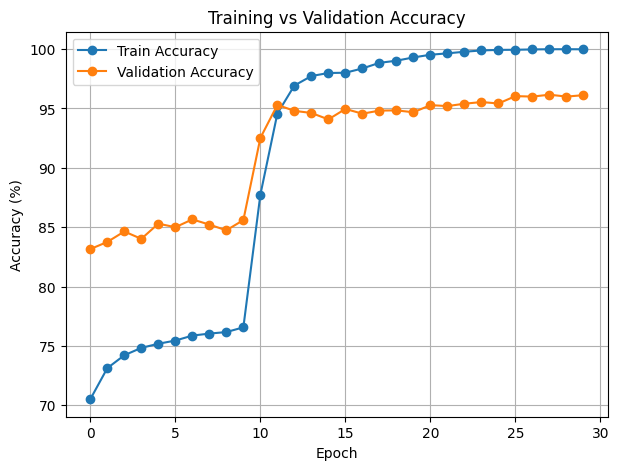

In [9]:
plt.figure(figsize=(7,5))
plt.plot(train_results["train_acc"], label="Train Accuracy", marker='o')
plt.plot(train_results["val_acc"], label="Validation Accuracy", marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

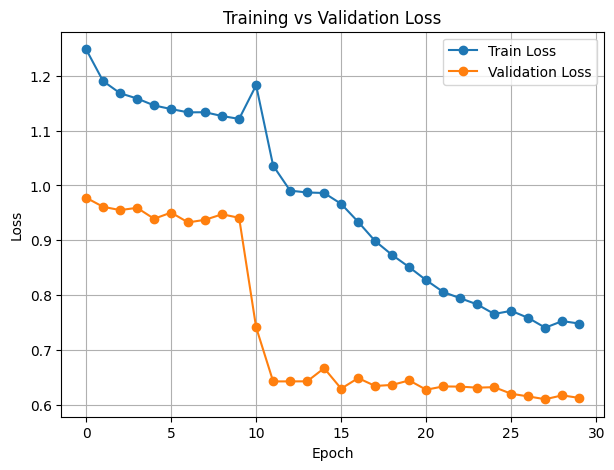

In [10]:
plt.figure(figsize=(7,5))
plt.plot(train_results["train_loss"], label="Train Loss", marker='o')
plt.plot(train_results["val_loss"], label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


Both the validation loss and accuracy seem to be decreasing steadily. This suggests that the model likely would have benefitted from more training time, increasing the number of epochs.

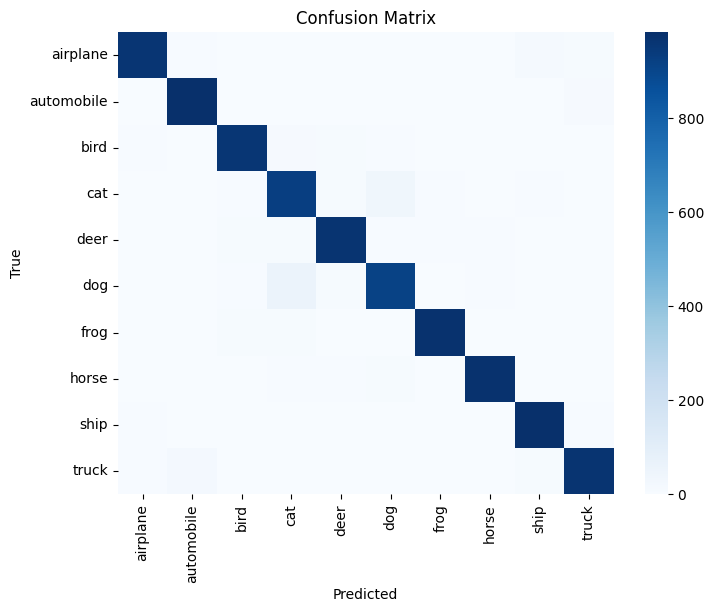

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(test_metrics_uncal["confusion_matrix"],
            annot=False,
            cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


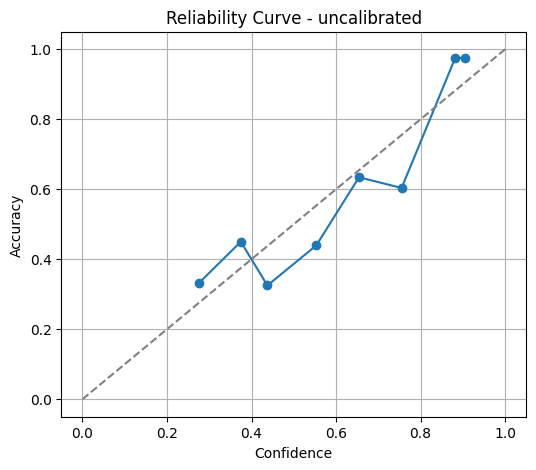

In [13]:
plt.figure(figsize=(6,5))
plt.plot(test_metrics_uncal["reliability_conf"], test_metrics_uncal["reliability_acc"], marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("Reliability Curve - uncalibrated")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

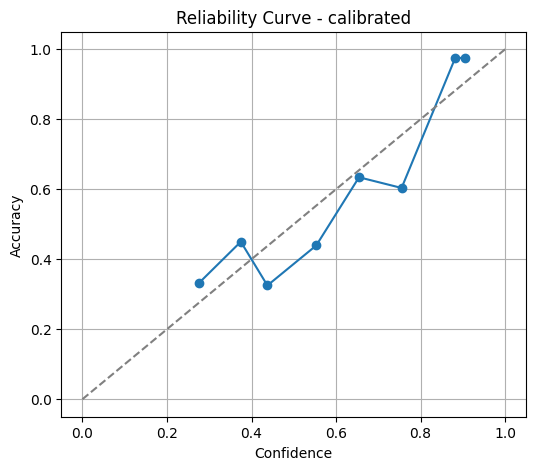

In [12]:
plt.figure(figsize=(6,5))
plt.plot(test_metrics_cal["reliability_conf"], test_metrics_cal["reliability_acc"], marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("Reliability Curve - calibrated")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

The model is mostly well calibrated, so does not benefit from temperature scaling.

## Knowledge Distilation

Knowledge Distilation (KD) is a "process [that] allows smaller models to inherit the strong capabilities of larger ones, avoiding the need for training from scratch and making powerful models more accessible" [(Huggingface.co, 2025)](https://huggingface.co/blog/Kseniase/kd). In this example, I'm going to use the larger trained ResNet50 and the ResNet18 models a teacher to a new ResNet18 model.

![knowledge distillation](kd.png)

[(Tran, 2021)](https://pub.towardsai.net/a-gentle-introduction-to-knowledge-distillation-6240bf8eb8ea)

In this example I do not expect the final KD model to outperform the ResNet18 model as I did not allow the ResNet50 model to show its full capabilites. Additionally, this method no longer works solely on my GPU, so is severley hampered by having to be completed on the GPU and the CPU. As such, for this example, I will be fine tuning the KD model using a random sample of 10k training images. Given these constraints, I expect this experiment not to show its full potential. However, there is some research suggesting that even if the teacher is weaker than the student [(Lee et al., 2023)](https://aclanthology.org/2023.findings-acl.714.pdf), or even if the student teaches itself[(Furlanello et al., 2018)](https://arxiv.org/abs/1805.04770), gains can still be made, particularly if both models are making different types of mistake (e.g. one is good at identifying cats and one is good at identifying dogs) 

The workflow below is a multi-teacher distillation workflow. I have chosen this to illustrate this method because it gives the ability to target models to certain benefits (e.g. one teacher is better at identifying machines and one is better at identifying animals etc.). In this example I have used the EMA smoothed weights from ResNet50 and the EMA smoothed weights from the ResNet18, combining the results from both models into a single signal for a new ResNet18 model. KD requires a model that is still learning, else the signal from the teacher is too weak to help teach it (i.e. the student thinks it knows everything already and doesn't listen to the teacher), for this example, the pre-trained ResNet18 may already be too accurate for this application. Additionally, teachers that are over confident can lead to a poor signal for the learner (i.e. only gives the student a single answer and no information to learn from). Therefore the ResNet50 model (which is quite well calibrated, smoothed via EMA and label smoothing and stopped early) and the ResNet18 model (which is not fully accurate, smoothed via EMA and label smoothing, but is over confident (without recalibration)) may prove to be excellent models to use as teachers. There are various papers studying this [(Cho and Hariharan, 2019)](https://arxiv.org/abs/1910.01348) and [(Phuong and Lampert, 2021)](https://arxiv.org/abs/2105.13093) being two such sources. Additionally, label smoothing and regularisation methods (cutmix/mixup and label smoothing) have been dropped as the teacher will already be providing soft targets.

Temperature scaling is used to soften logits during training, exagerating learning signals. For this, T=4 is generally used [(Hinton, Vinyals and Dean, 2015)](https://arxiv.org/abs/1503.02531) although some newer papers look at the advantages of a more dynamic approach to T [(Li et al., 2022)](https://arxiv.org/abs/2211.16231).

In [1]:
import os
import time
import math
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================================
# Config and paths
# =====================================================================
DATA_ROOT = "./data"
CHECKPOINT_DIR = "./checkpoints_kd"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 10

BATCH_SIZE_TRAIN = 128
BATCH_SIZE_EVAL = 128
VAL_SPLIT = 0.1

KD_SUBSET_SIZE = 10000

# Paths to existing trained models (teacher50 + teacher18/student EMA)
TEACHER_WEIGHTS_PATH = "checkpoints_resnet50_full_tune/resnet50_best_weights.pth"
TEACHER_TEMP_PATH    = "checkpoints_resnet50_full_tune/temperature.pt"

STUDENT_WEIGHTS_PATH = "checkpoints_resnet18_full_tune/resnet18_best_weights.pth"
STUDENT_TEMP_PATH    = "checkpoints_resnet18_full_tune/temperature.pt"

DISTILLED_WEIGHTS_PATH = "checkpoints_resnet18_full_tune/distilled_weights_kd_full.pth"
DISTILLED_TEMP_PATH    = "checkpoints_resnet18_full_tune/distilled_temperature_kd_full.pt"


# =====================================================================
# Data: CIFAR-10 with stratified train/val split
# =====================================================================
transform = transforms.Compose([
    transforms.Resize(160),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

trainset_full = torchvision.datasets.CIFAR10(
    root=DATA_ROOT, train=True, download=True, transform=transform
)

targets = np.array(trainset_full.targets)
sss = StratifiedShuffleSplit(
    n_splits=1, test_size=VAL_SPLIT, random_state=42
)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

trainset = Subset(trainset_full, train_idx)
valset = Subset(trainset_full, val_idx)

# =====================================================================
# KD subset: first 10,000 samples from the training split
# =====================================================================

kd_indices = list(range(min(KD_SUBSET_SIZE, len(trainset))))
kd_trainset = Subset(trainset, kd_indices)

trainloader = DataLoader(
    kd_trainset,
    batch_size=BATCH_SIZE_TRAIN,
    shuffle=True,
    num_workers=1,
    pin_memory=False
)

print(f"Using KD subset of size {len(kd_trainset)}")

valloader = DataLoader(
    valset, batch_size=BATCH_SIZE_EVAL,
    shuffle=False, num_workers=1, pin_memory=False
)

testset = torchvision.datasets.CIFAR10(
    root=DATA_ROOT, train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=BATCH_SIZE_EVAL,
    shuffle=False, num_workers=1, pin_memory=False
)

classes = trainset_full.classes


# =====================================================================
# Metrics: ECE and evaluation
# =====================================================================
def compute_ece(probs, labels, n_bins=15):
    confidences, predictions = probs.max(dim=1)
    accuracies = predictions.eq(labels)

    ece = torch.zeros(1, dtype=torch.float32)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    for bin_lower, bin_upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            acc_in_bin = accuracies[in_bin].float().mean()
            avg_conf_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_conf_in_bin - acc_in_bin) * prop_in_bin

    return ece.item()


def evaluate_model(model, dataloader, device, temperature=None, n_bins=15):
    model = model.to(device)
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    all_logits = torch.cat(all_logits, dim=0)  # on CPU
    all_labels = torch.cat(all_labels, dim=0)  # on CPU

    if temperature is not None:
        if isinstance(temperature, torch.Tensor):
            T = temperature.detach().cpu()
            all_logits = all_logits / T
        else:
            all_logits = all_logits / float(temperature)

    probs = torch.softmax(all_logits, dim=1)
    conf, preds = probs.max(dim=1)

    correct = preds.eq(all_labels)
    accuracy = correct.float().mean().item()

    nll = F.nll_loss(torch.log(probs + 1e-12), all_labels).item()
    ece = compute_ece(probs, all_labels, n_bins=n_bins)

    conf_np = conf.detach().cpu().numpy()
    correct_np = correct.detach().cpu().numpy()

    metrics = {
        "accuracy": accuracy,
        "nll": nll,
        "ece": ece,
        "confidences": conf_np,
        "correct": correct_np,
    }
    return metrics


# =====================================================================
# Simple eval for train/val loss & accuracy
# =====================================================================
def evaluate_simple(model, dataloader, device):
    model = model.to(device)
    model.eval()
    ce = nn.CrossEntropyLoss()

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = ce(logits, y)
            running_loss += loss.item()

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = running_loss / len(dataloader)
    acc = correct / total if total > 0 else 0.0
    return avg_loss, acc


# =====================================================================
# Temperature scaling (fit_temperature)
# =====================================================================
class _TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, logits):
        return logits / self.temperature


def fit_temperature(model, dataloader, device="cpu"):
    model = model.to(device)
    model.eval()

    logits_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            logits_list.append(outputs)
            labels_list.append(labels)

    logits = torch.cat(logits_list).detach().cpu()
    labels = torch.cat(labels_list).detach().cpu()

    temp_scaler = _TemperatureScaler().to("cpu")

    nll_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.LBFGS([temp_scaler.temperature], lr=0.01, max_iter=50)

    def _eval():
        optimizer.zero_grad()
        scaled_logits = temp_scaler(logits)
        loss = nll_criterion(scaled_logits, labels)
        loss.backward()
        return loss

    optimizer.step(_eval)

    T = temp_scaler.temperature.detach().cpu()
    return T


# =====================================================================
# Multi-teacher KD setup
# =====================================================================
# Teacher A: ResNet-50 EMA (CPU, frozen)
teacher50 = torchvision.models.resnet50(weights=None)
teacher50.fc = nn.Linear(2048, NUM_CLASSES)
teacher50.load_state_dict(torch.load(TEACHER_WEIGHTS_PATH, map_location="cpu"))
teacher50.eval()
for p in teacher50.parameters():
    p.requires_grad = False
T_teacher50 = torch.load(TEACHER_TEMP_PATH, map_location="cpu")  # not used directly in KD

# Teacher B: ResNet-18 EMA (CPU, frozen)
teacher18 = torchvision.models.resnet18(weights=None)
teacher18.fc = nn.Linear(512, NUM_CLASSES)
teacher18.load_state_dict(torch.load(STUDENT_WEIGHTS_PATH, map_location="cpu"))
teacher18.eval()
for p in teacher18.parameters():
    p.requires_grad = False
T_teacher18 = torch.load(STUDENT_TEMP_PATH, map_location="cpu")  # not used directly in KD

# Student: ResNet-18 (GPU, trainable)
student = torchvision.models.resnet18(weights=None)
student.fc = nn.Linear(512, NUM_CLASSES)
student.load_state_dict(torch.load(STUDENT_WEIGHTS_PATH, map_location="cpu"))
student = student.to(device)
student.train()


# =====================================================================
# Multi-teacher KD loss
# =====================================================================
class MultiTeacherKDLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.5, beta=0.5):
        super().__init__()
        self.temperature = temperature  # KD temperature
        self.alpha = alpha              # weight for soft vs hard loss
        self.beta = beta                # weight for teacher50 vs teacher18
        self.ce = nn.CrossEntropyLoss()
        self.kl = nn.KLDivLoss(reduction="batchmean")

    def forward(self, student_logits, teacher50_logits, teacher18_logits, labels):
        T = self.temperature

        teacher_mix = self.beta * teacher50_logits + (1 - self.beta) * teacher18_logits

        hard_loss = self.ce(student_logits, labels)

        soft_loss = self.kl(
            F.log_softmax(student_logits / T, dim=1),
            F.softmax(teacher_mix / T, dim=1)
        ) * (T * T)

        return (1 - self.alpha) * hard_loss + self.alpha * soft_loss


# =====================================================================
# KD training loop with cosine annealing + train/val metrics
# =====================================================================
kd_loss_fn = MultiTeacherKDLoss(temperature=4.0, alpha=0.5, beta=0.5)

EPOCHS_KD = 8
BASE_LR_KD = 1e-4

optimizer = torch.optim.Adam(student.parameters(), lr=BASE_LR_KD)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS_KD,
    eta_min=1e-6
)

train_losses = []
val_losses = []
train_accs = []
val_accs = []

print(f"Starting KD on sample train split (size {len(kd_trainset)})...")
for epoch in range(1, EPOCHS_KD + 1):
    epoch_start = time.time()

    student.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for inputs, labels in trainloader:
        labels = labels.to(device)

        with torch.no_grad():
            t50_logits = teacher50(inputs)   # CPU
            t18_logits = teacher18(inputs)   # CPU

        inputs_gpu = inputs.to(device)
        t50_logits = t50_logits.to(device)
        t18_logits = t18_logits.to(device)

        s_logits = student(inputs_gpu)

        loss = kd_loss_fn(s_logits, t50_logits, t18_logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = s_logits.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    scheduler.step()

    avg_train_loss = running_loss / len(trainloader)
    train_acc = running_correct / running_total if running_total > 0 else 0.0

    val_loss, val_acc = evaluate_simple(student, valloader, device)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    epoch_time = time.time() - epoch_start

    print(
        f"Epoch {epoch}/{EPOCHS_KD} | "
        f"TrainLoss {avg_train_loss:.4f} | "
        f"TrainAcc {train_acc*100:.2f}% | "
        f"ValLoss {val_loss:.4f} | "
        f"ValAcc {val_acc*100:.2f}% | "
        f"Time {epoch_time:.1f}s"
    )


# =====================================================================
# Save distilled student + fit temperature
# =====================================================================
torch.save(student.state_dict(), DISTILLED_WEIGHTS_PATH)
print(f"\nSaved distilled student weights to: {DISTILLED_WEIGHTS_PATH}")

student_cpu = student.to("cpu")

print("\nFitting temperature for distilled student on validation set (CPU eval)...")
T_distilled = fit_temperature(student_cpu, valloader, device="cpu")
T_distilled = T_distilled.detach().cpu()
torch.save(T_distilled, DISTILLED_TEMP_PATH)
print(f"Distilled student temperature: {T_distilled.item():.4f}")
print(f"Saved distilled temperature to: {DISTILLED_TEMP_PATH}")





Using KD subset of size 10000
Starting KD on sample train split (size 10000)...
Epoch 1/8 | TrainLoss 0.1013 | TrainAcc 98.55% | ValLoss 0.2086 | ValAcc 95.26% | Time 540.3s
Epoch 2/8 | TrainLoss 0.0751 | TrainAcc 99.86% | ValLoss 0.2055 | ValAcc 95.28% | Time 581.7s
Epoch 3/8 | TrainLoss 0.0586 | TrainAcc 99.99% | ValLoss 0.2048 | ValAcc 95.34% | Time 585.4s
Epoch 4/8 | TrainLoss 0.0551 | TrainAcc 99.98% | ValLoss 0.2049 | ValAcc 95.34% | Time 608.3s
Epoch 5/8 | TrainLoss 0.0514 | TrainAcc 100.00% | ValLoss 0.2020 | ValAcc 95.40% | Time 606.8s
Epoch 6/8 | TrainLoss 0.0491 | TrainAcc 100.00% | ValLoss 0.2034 | ValAcc 95.38% | Time 616.8s
Epoch 7/8 | TrainLoss 0.0487 | TrainAcc 100.00% | ValLoss 0.2039 | ValAcc 95.40% | Time 599.5s
Epoch 8/8 | TrainLoss 0.0474 | TrainAcc 100.00% | ValLoss 0.2045 | ValAcc 95.50% | Time 606.9s

Saved distilled student weights to: checkpoints_resnet18_full_tune/distilled_weights_kd_full.pth

Fitting temperature for distilled student on validation set (CPU 

In [13]:
# =====================================================================
# Final evaluation on test set
# =====================================================================
metrics_uncal = evaluate_model(student_cpu, testloader, device="cpu", temperature=None)
metrics_cal = evaluate_model(student_cpu, testloader, device="cpu", temperature=T_distilled)

def plot_reliability(confidences, correct, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)

    accs = []
    confs = []

    for i in range(n_bins):
        mask = (confidences >= bins[i]) & (confidences < bins[i+1])
        if mask.sum() > 0:
            accs.append(correct[mask].mean())
            confs.append(confidences[mask].mean())
        else:
            accs.append(np.nan)
            confs.append(np.nan)

    plt.figure(figsize=(6,6))
    plt.plot(confs, accs, marker="o", label="Model")
    plt.plot([0,1], [0,1], "--", color="gray", label="Perfect Calibration")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion(model, dataloader, device, classes):
    model = model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm, 
        annot=True,
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [19]:
print(
    f"accuracy: {metrics_uncal['accuracy']}\n"
)

accuracy: 0.9538999795913696



Within 8 epochs we have >95% accuracy. The full train workflow for ResNet18 achieved ~94% validation accuracy (likeley real accuracy would be lower) with a warm up of 5 epochs, 8 full train epochs and access to 4x the amount of training data. This could present a remarkable way to train a model, both for performance reasons (quicker to provide an output) and to condense multiple areas of knowledge into one model.

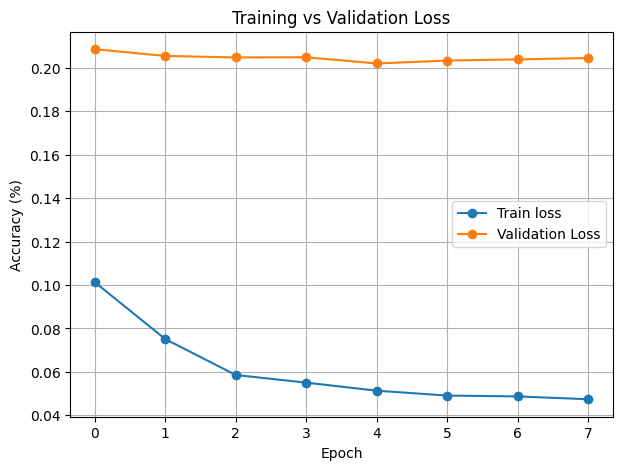

In [7]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

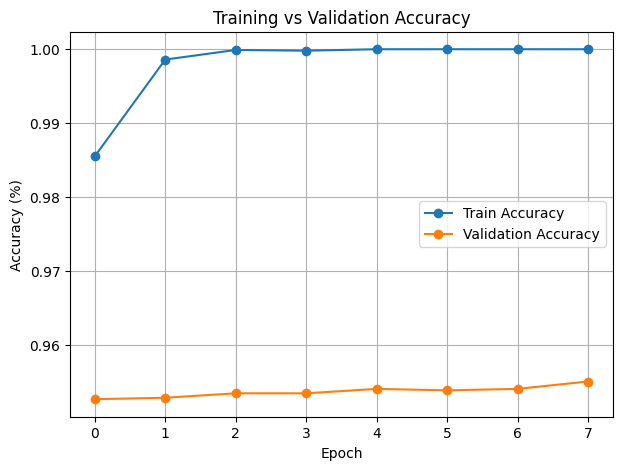

In [6]:
plt.figure(figsize=(7,5))
plt.plot(train_accs, label="Train Accuracy", marker='o')
plt.plot(val_accs, label="Validation Accuracy", marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

Additionally when we look at the loss and accuracy per epoch, it's likely with more epochs, more could have been achieved. Additionally, the model appears to have suffered recieving less training materials, reaching 100% validation accuracy within 3 epochs.

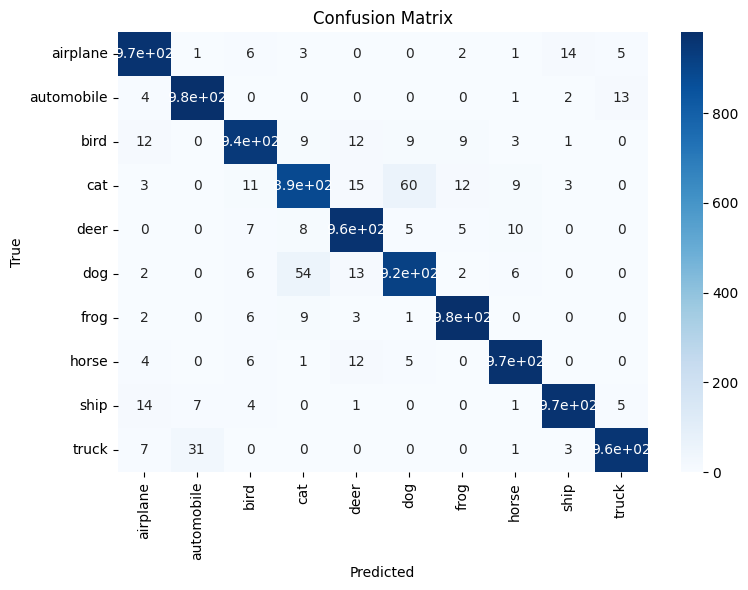

In [14]:
plot_confusion(student_cpu, testloader, "cpu", classes)

Again cats and dogs, seem to be the main error.

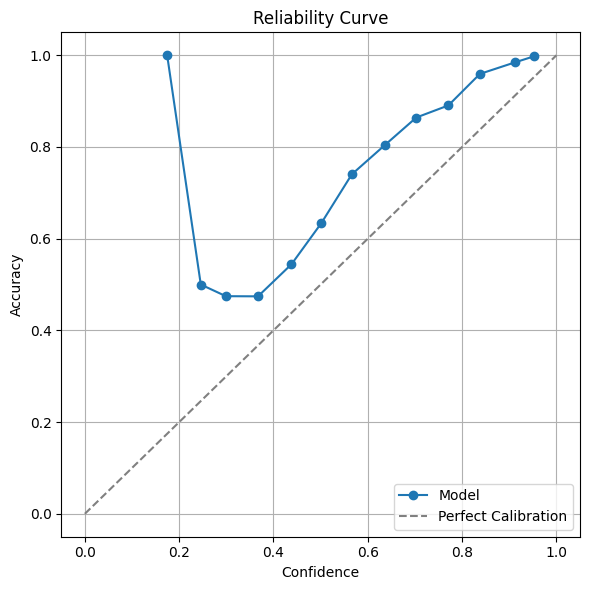

In [15]:
plot_reliability(metrics_uncal["confidences"], metrics_uncal["correct"])

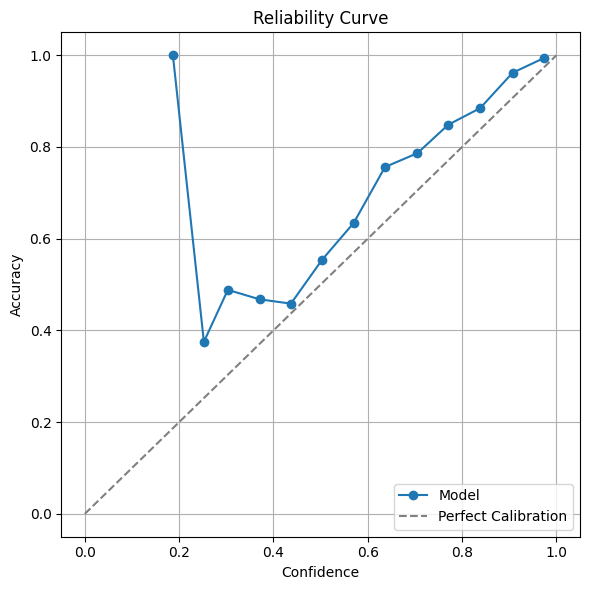

In [16]:
plot_reliability(metrics_cal["confidences"], metrics_cal["correct"])

This model was quite well calibrated to begin with, but temperature scaling has helped somewhat.

In [22]:
print(
    f"uncalibrated ECE: {metrics_uncal['ece']}\n",
    f"calibrated ECE: {metrics_cal['ece']}"
)

uncalibrated ECE: 0.07141921669244766
 calibrated ECE: 0.030686233192682266


# Conclusion

There are a multitude of different approaches to statistical analysis, machine learning and deep learning. Each method has its own strengths and weaknesses, and its own correct application. I have achieved the aim of this document; to train a model to better than human levels of accuracy (~93%). Further improving the accuracy is possible, as demonstrated by [(Gautam, Yogesh Lohumi and Durgaprasad Gangodkar, 2024)](https://ieeexplore.ieee.org/document/10690610) achiveing 99.9% accuracy, but the methods used lie outside of the scope of this document.

# References

Al-Mejibli, I.S., Abd, D.H., Alwan, J.K. and Rabash, A.J. (2018). Performance Evaluation of Kernels in Support Vector Machine. 2018 1st Annual International Conference on Information and Sciences (AiCIS). doi:https://doi.org/10.1109/aicis.2018.00029.
Brownlee, J. (2019). How to Choose Loss Functions When Training Deep Learning Neural Networks. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/.
Cao, Z., Li, Y., Kim, D.-H. and Shin, B.-S. (2024). Deep Neural Network Confidence Calibration from Stochastic Weight Averaging. Electronics, [online] 13(3), p.503. doi:https://doi.org/10.3390/electronics13030503.
Furlanello, T., Lipton, Z.C., Tschannen, M., Itti, L. and Anandkumar, A. (2018). Born Again Neural Networks. [online] arXiv.org. Available at: https://arxiv.org/abs/1805.04770.
Gautam, A., Yogesh Lohumi and Durgaprasad Gangodkar (2024). Achieving Near-Perfect Accuracy in CIFAR-10 Classification. [online] pp.1–6. doi:https://doi.org/10.1109/icait61638.2024.10690610.
GeeksforGeeks (2019). CNN | Introduction to Pooling Layer. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/deep-learning/cnn-introduction-to-pooling-layer/.
GeeksforGeeks (2020). StandardScaler, MinMaxScaler and RobustScaler techniques ML. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/machine-learning/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/.
GeeksforGeeks (2021). MultiLayer Perceptron Learning in Tensorflow. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/deep-learning/multi-layer-perceptron-learning-in-tensorflow/.
GeeksforGeeks (2024). Building a Convolutional Neural Network using PyTorch. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/deep-learning/building-a-convolutional-neural-network-using-pytorch/.
Grootendorst, M.P. (2024). 2. Dimensionality Reduction - BERTopic. [online] Github.io. Available at: https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html.
Guo, C., Pleiss, G., Sun, Y. and Weinberger, K.Q. (2017). On Calibration of Modern Neural Networks. arXiv:1706.04599 [cs]. [online] Available at: https://arxiv.org/abs/1706.04599.
He, K., Zhang, X., Ren, S. and Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification. [online] arXiv.org. Available at: https://arxiv.org/abs/1502.01852.
Hinton, G., Vinyals, O. and Dean, J. (2015). Distilling the Knowledge in a Neural Network. arXiv:1503.02531 [cs, stat]. [online] Available at: https://arxiv.org/abs/1503.02531.
Ho-Phuoc, T. (2019). CIFAR10 to Compare Visual Recognition Performance between Deep Neural Networks and Humans. arXiv:1811.07270 [cs]. [online] Available at: https://arxiv.org/abs/1811.07270.
Huggingface.co. (2025). Blocked Page. [online] Available at: https://huggingface.co/blog/Kseniase/kd.
Kingma, D.P. and Ba, J. (2014). Adam: A Method for Stochastic Optimization. [online] arXiv. Available at: https://arxiv.org/abs/1412.6980.
Kundu, R. (2022). F1 Score in Machine Learning: Intro & Calculation. [online] V7. Available at: https://www.v7labs.com/blog/f1-score-guide.
Lee, H., Hou, R., Kim, J., Liang, D., Hwang, S., Min, A., Kaist and Ai, M. (2023). A Study on Knowledge Distillation from Weak Teacher for Scaling Up Pre-trained Language Models. [online] pp.11239–11246. Available at: https://aclanthology.org/2023.findings-acl.714.pdf [Accessed 3 Jan. 2026].
Li, Z., Li, X., Yang, L., Zhao, B., Song, R., Luo, L., Li, J. and Yang, J. (2022). Curriculum Temperature for Knowledge Distillation. [online] arXiv.org. doi:https://doi.org/10.48550/arXiv.2211.16231.
Mathworks.com. (2025). Go to GoGuardian App. [online] Available at: https://www.mathworks.com/matlabcentral/fileexchange/130784-normalized-mutual-information-nmi-for-cluster-analysis [Accessed 16 Dec. 2025].
Medium.com. (2024). Page Restricted. [online] Available at: https://farshadabdulazeez.medium.com/understanding-silhouette-score-in-clustering-8aedc06ce9c4.
Medium.com. (2025). Blocked. [online] Available at: https://medium.com/data-science/on-the-validating-umap-embeddings-2c8907588175 [Accessed 16 Dec. 2025].
Morales-Brotons, D., Vogels, T. and Hendrikx, H. (2024). Exponential Moving Average of Weights in Deep Learning: Dynamics and Benefits. [online] arXiv.org. Available at: https://arxiv.org/abs/2411.18704.
Phuong, M. and Lampert, C.H. (2021). Towards Understanding Knowledge Distillation. [online] arXiv.org. Available at: https://arxiv.org/abs/2105.13093 [Accessed 3 Jan. 2026].
PyTorch Contributors (2023). ReduceLROnPlateau. [online] Pytorch.org. Available at: https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#reducelronplateau [Accessed 30 Dec. 2025].
PyTorch Contributors (2025). CosineAnnealingLR. [online] Pytorch.org. Available at: https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html.
Rodrigo Rico Gómez, Lorentz, J., Hartmann, T., Arda Goknil, Inder Pal Singh, Tayfun Gökmen Halaç and Gülnaz Boruzanlı Ekinci (2024). An AI pipeline for garment price projection using computer vision. Neural computing & applications. doi:https://doi.org/10.1007/s00521-024-09901-w.
Schaijk, T. van (n.d.). Image classification: MLP vs CNN. [online] www.peculiar-coding-endeavours.com. Available at: https://www.peculiar-coding-endeavours.com/2019/mlp_vs_cnn/.
Selvaraju, R.R., Cogswell, M., Das, A., Vedantam, R., Parikh, D. and Batra, D. (2020). Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization. International Journal of Computer Vision, 128(2), pp.336–359. doi:https://doi.org/10.1007/s11263-019-01228-7.
Slingacademy.com. (2025). Welcome To Zscaler Directory Authentication. [online] Available at: https://www.slingacademy.com/article/advanced-parameter-freezing-techniques-in-pytorch-transfer-learning/ [Accessed 30 Dec. 2025].
Smith, L.N. and Topin, N. (2018). Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates. arXiv:1708.07120 [cs, stat]. [online] Available at: https://arxiv.org/abs/1708.07120.
Tam, A. (2023). Building Multilayer Perceptron Models in PyTorch - MachineLearningMastery.com. [online] MachineLearningMastery.com. Available at: https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/.
Tran, L. (2021). A Gentle Introduction to Hint Learning & Knowledge Distillation. [online] Medium. Available at: https://pub.towardsai.net/a-gentle-introduction-to-knowledge-distillation-6240bf8eb8ea.
Tsang, S.-H. (2020). [Paper] CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features…. [online] Medium. Available at: https://sh-tsang.medium.com/paper-cutmix-regularization-strategy-to-train-strong-classifiers-with-localizable-features-5527e29c4890 [Accessed 2 Jan. 2026].
Wikipedia Contributors (2024). Leakage (machine learning). [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/Leakage_(machine_learning)
www.pytorch.org. (n.d.). PyTorch. [online] Available at: https://pytorch.org/hub/pytorch_vision_resnet/.
www.sciencedirect.com. (n.d.). Adjusted Rand Index - an overview | ScienceDirect Topics. [online] Available at: https://www.sciencedirect.com/topics/computer-science/adjusted-rand-index.